# <Chapter 4_분류>

# 07 LightGBM

## 07.1 LightGBM 설치

## 07.2 LightGBM 하이퍼 파라미터

## 07.3 하이퍼 파라미터 튜닝 방안

## 07.4 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교

## 07.5 LightGBM 적용 - 위스콘신 유방암 예측

In [1]:
import lightgbm

In [2]:
print(lightgbm.__version__)

3.3.5


In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


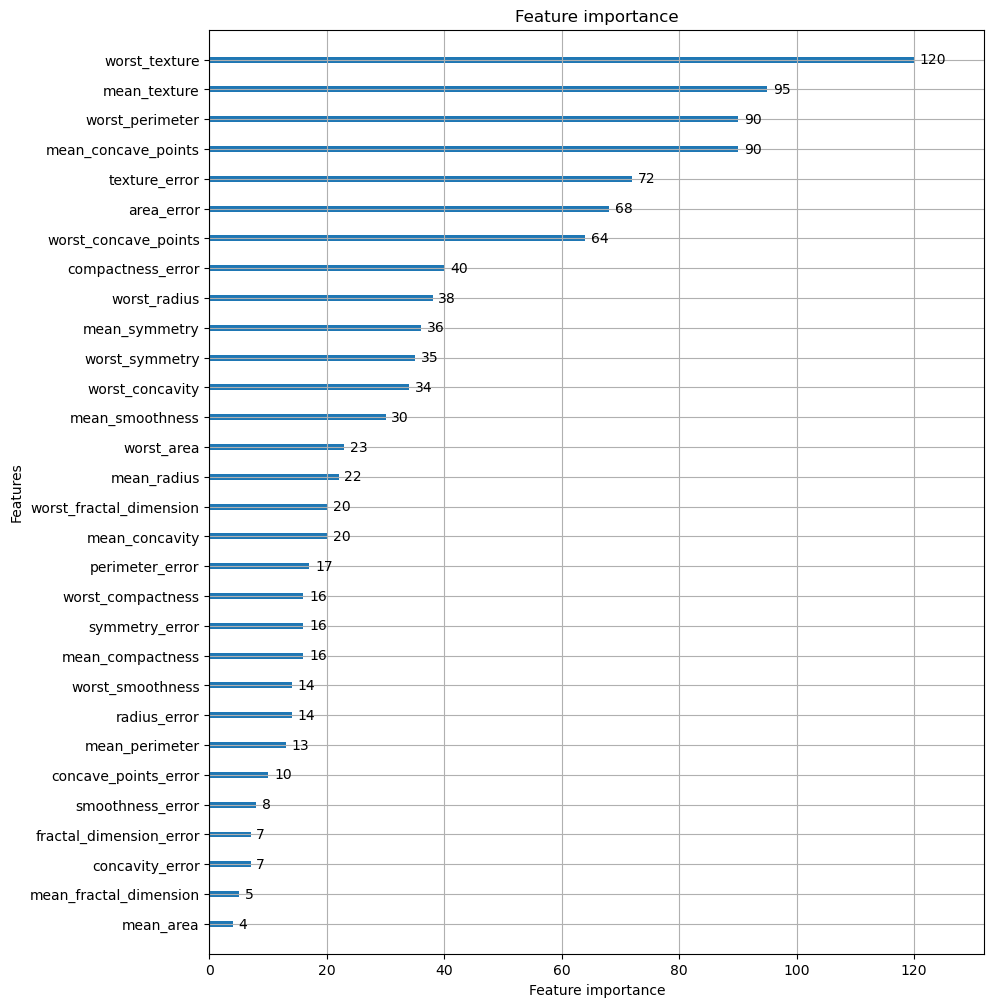

In [6]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

# 08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

## 08.1 베이지안 최적화 개요

## 08.2 HyperOpt 사용하기

In [7]:
import hyperopt

In [8]:
print(hyperopt.__version__)

0.2.7


In [9]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

In [10]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

In [11]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.29trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [12]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1091.27trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [13]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [14]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [15]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


## 08.3 HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

위스콘신 유방암 데이터 세트를 다시 로딩하여 학습, 검증, 테스트 데이터로 분리

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [17]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [18]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [19]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [20]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [21]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [23]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29513
[15]	validation_0-logloss:0.11926	validation_1-logloss:0.28891
[1

[130]	validation_0-logloss:0.01639	validation_1-logloss:0.22934
[131]	validation_0-logloss:0.01634	validation_1-logloss:0.22987
[132]	validation_0-logloss:0.01629	validation_1-logloss:0.22927
[133]	validation_0-logloss:0.01624	validation_1-logloss:0.23076
[134]	validation_0-logloss:0.01620	validation_1-logloss:0.23030
[135]	validation_0-logloss:0.01615	validation_1-logloss:0.22891
[136]	validation_0-logloss:0.01610	validation_1-logloss:0.22883
[137]	validation_0-logloss:0.01606	validation_1-logloss:0.22882
[138]	validation_0-logloss:0.01601	validation_1-logloss:0.22876
[139]	validation_0-logloss:0.01597	validation_1-logloss:0.22734
[140]	validation_0-logloss:0.01592	validation_1-logloss:0.22882
[141]	validation_0-logloss:0.01588	validation_1-logloss:0.22935
[142]	validation_0-logloss:0.01583	validation_1-logloss:0.22880
[143]	validation_0-logloss:0.01579	validation_1-logloss:0.22856
[144]	validation_0-logloss:0.01575	validation_1-logloss:0.22725
[145]	validation_0-logloss:0.01571	valid

# 09 분류 실습 - 캐글 산탄데르 고객 만족 예측

## 09.1 데이터 전처리

In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [28]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [29]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [30]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [31]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [32]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [34]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

## 09.2 XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

[149]	validation_0-auc:0.90500	validation_1-auc:0.83353
[150]	validation_0-auc:0.90513	validation_1-auc:0.83352
[151]	validation_0-auc:0.90531	validation_1-auc:0.83349
[152]	validation_0-auc:0.90548	validation_1-auc:0.83349
[153]	validation_0-auc:0.90551	validation_1-auc:0.83351
[154]	validation_0-auc:0.90563	validation_1-auc:0.83348
[155]	validation_0-auc:0.90572	validation_1-auc:0.83343
[156]	validation_0-auc:0.90579	validation_1-auc:0.83344
[157]	validation_0-auc:0.90591	validation_1-auc:0.83345
[158]	validation_0-auc:0.90621	validation_1-auc:0.83355
[159]	validation_0-auc:0.90630	validation_1-auc:0.83359
[160]	validation_0-auc:0.90643	validation_1-auc:0.83356
[161]	validation_0-auc:0.90657	validation_1-auc:0.83352
[162]	validation_0-auc:0.90672	validation_1-auc:0.83346
[163]	validation_0-auc:0.90694	validation_1-auc:0.83347
[164]	validation_0-auc:0.90714	validation_1-auc:0.83343
[165]	validation_0-auc:0.90720	validation_1-auc:0.83343
[166]	validation_0-auc:0.90727	validation_1-auc:

In [36]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [38]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[68]	validation_0-auc:0.89250	validation_1-auc:0.83282                                                                 
[69]	validation_0-auc:0.89269	validation_1-auc:0.83292                                                                 
[70]	validation_0-auc:0.89308	validation_1-auc:0.83292                                                                 
[71]	validation_0-auc:0.89361	validation_1-auc:0.83264                                                                 
[72]	validation_0-auc:0.89406	validation_1-auc:0.83256                                                                 
[73]	validation_0-auc:0.89430	validation_1-auc:0.83239                                                                 
[74]	validation_0-auc:0.89457	validation_1-auc:0.83261                                                                 
[75]	validation_0-auc:0.89482	validation_1-auc:0.83233                                                                 
[76]	validation_0-auc:0.89494	validation

[46]	validation_0-auc:0.88228	validation_1-auc:0.83625                                                                 
[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88499	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88617	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88688	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88846	validation

[14]	validation_0-auc:0.85451	validation_1-auc:0.82647                                                                 
[15]	validation_0-auc:0.85543	validation_1-auc:0.82596                                                                 
[16]	validation_0-auc:0.85660	validation_1-auc:0.82658                                                                 
[17]	validation_0-auc:0.85740	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.85886	validation_1-auc:0.82679                                                                 
[19]	validation_0-auc:0.85976	validation_1-auc:0.82722                                                                 
[20]	validation_0-auc:0.86042	validation_1-auc:0.82733                                                                 
[21]	validation_0-auc:0.86157	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.86180	validation

[82]	validation_0-auc:0.90020	validation_1-auc:0.83718                                                                 
[83]	validation_0-auc:0.90074	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90102	validation_1-auc:0.83728                                                                 
[85]	validation_0-auc:0.90138	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90155	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90164	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90170	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90205	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90245	validation

[50]	validation_0-auc:0.90297	validation_1-auc:0.83051                                                                 
[51]	validation_0-auc:0.90418	validation_1-auc:0.83055                                                                 
[52]	validation_0-auc:0.90464	validation_1-auc:0.83076                                                                 
[53]	validation_0-auc:0.90548	validation_1-auc:0.82978                                                                 
[54]	validation_0-auc:0.90591	validation_1-auc:0.82956                                                                 
[55]	validation_0-auc:0.90659	validation_1-auc:0.82993                                                                 
[56]	validation_0-auc:0.90670	validation_1-auc:0.82961                                                                 
[57]	validation_0-auc:0.90711	validation_1-auc:0.82938                                                                 
[58]	validation_0-auc:0.90798	validation

[39]	validation_0-auc:0.89170	validation_1-auc:0.82861                                                                 
[40]	validation_0-auc:0.89309	validation_1-auc:0.82975                                                                 
[41]	validation_0-auc:0.89324	validation_1-auc:0.82911                                                                 
[42]	validation_0-auc:0.89552	validation_1-auc:0.82967                                                                 
[43]	validation_0-auc:0.89671	validation_1-auc:0.82997                                                                 
[44]	validation_0-auc:0.89801	validation_1-auc:0.83066                                                                 
[45]	validation_0-auc:0.89859	validation_1-auc:0.83087                                                                 
[46]	validation_0-auc:0.89944	validation_1-auc:0.83136                                                                 
[47]	validation_0-auc:0.90083	validation

[7]	validation_0-auc:0.85814	validation_1-auc:0.82231                                                                  
[8]	validation_0-auc:0.85953	validation_1-auc:0.82212                                                                  
[9]	validation_0-auc:0.86282	validation_1-auc:0.82205                                                                  
[10]	validation_0-auc:0.86284	validation_1-auc:0.82076                                                                 
[11]	validation_0-auc:0.86207	validation_1-auc:0.82028                                                                 
[12]	validation_0-auc:0.86463	validation_1-auc:0.82218                                                                 
[13]	validation_0-auc:0.86692	validation_1-auc:0.82317                                                                 
[14]	validation_0-auc:0.86878	validation_1-auc:0.82529                                                                 
[15]	validation_0-auc:0.86830	validation

[75]	validation_0-auc:0.91973	validation_1-auc:0.83107                                                                 
[76]	validation_0-auc:0.92015	validation_1-auc:0.83147                                                                 
[77]	validation_0-auc:0.92044	validation_1-auc:0.83143                                                                 
[78]	validation_0-auc:0.92071	validation_1-auc:0.83193                                                                 
[79]	validation_0-auc:0.92112	validation_1-auc:0.83232                                                                 
[80]	validation_0-auc:0.92183	validation_1-auc:0.83284                                                                 
[81]	validation_0-auc:0.92233	validation_1-auc:0.83290                                                                 
[82]	validation_0-auc:0.92249	validation_1-auc:0.83322                                                                 
[83]	validation_0-auc:0.92302	validation

[43]	validation_0-auc:0.93603	validation_1-auc:0.82574                                                                 
[44]	validation_0-auc:0.93697	validation_1-auc:0.82628                                                                 
[45]	validation_0-auc:0.93714	validation_1-auc:0.82631                                                                 
[46]	validation_0-auc:0.93740	validation_1-auc:0.82635                                                                 
[47]	validation_0-auc:0.93805	validation_1-auc:0.82599                                                                 
[48]	validation_0-auc:0.93842	validation_1-auc:0.82550                                                                 
[49]	validation_0-auc:0.93865	validation_1-auc:0.82571                                                                 
[50]	validation_0-auc:0.93910	validation_1-auc:0.82567                                                                 
[51]	validation_0-auc:0.93932	validation

[52]	validation_0-auc:0.94317	validation_1-auc:0.83200                                                                 
[53]	validation_0-auc:0.94377	validation_1-auc:0.83222                                                                 
[54]	validation_0-auc:0.94421	validation_1-auc:0.83209                                                                 
[55]	validation_0-auc:0.94461	validation_1-auc:0.83226                                                                 
[56]	validation_0-auc:0.94480	validation_1-auc:0.83226                                                                 
[57]	validation_0-auc:0.94494	validation_1-auc:0.83221                                                                 
[58]	validation_0-auc:0.94502	validation_1-auc:0.83211                                                                 
[59]	validation_0-auc:0.94535	validation_1-auc:0.83220                                                                 
[60]	validation_0-auc:0.94568	validation

[29]	validation_0-auc:0.92709	validation_1-auc:0.83202                                                                 
[30]	validation_0-auc:0.92830	validation_1-auc:0.83131                                                                 
[31]	validation_0-auc:0.92964	validation_1-auc:0.83176                                                                 
[32]	validation_0-auc:0.93091	validation_1-auc:0.83183                                                                 
[33]	validation_0-auc:0.93168	validation_1-auc:0.83129                                                                 
[34]	validation_0-auc:0.93268	validation_1-auc:0.83132                                                                 
[35]	validation_0-auc:0.93400	validation_1-auc:0.83161                                                                 
[36]	validation_0-auc:0.93478	validation_1-auc:0.83178                                                                 
[37]	validation_0-auc:0.93588	validation

[10]	validation_0-auc:0.85088	validation_1-auc:0.81170                                                                 
[11]	validation_0-auc:0.85254	validation_1-auc:0.81344                                                                 
[12]	validation_0-auc:0.85442	validation_1-auc:0.81525                                                                 
[13]	validation_0-auc:0.85777	validation_1-auc:0.81538                                                                 
[14]	validation_0-auc:0.85831	validation_1-auc:0.81600                                                                 
[15]	validation_0-auc:0.86014	validation_1-auc:0.81717                                                                 
[16]	validation_0-auc:0.86258	validation_1-auc:0.81812                                                                 
[17]	validation_0-auc:0.86392	validation_1-auc:0.82040                                                                 
[18]	validation_0-auc:0.86335	validation

[78]	validation_0-auc:0.91749	validation_1-auc:0.83294                                                                 
[79]	validation_0-auc:0.91803	validation_1-auc:0.83302                                                                 
[80]	validation_0-auc:0.91863	validation_1-auc:0.83357                                                                 
[81]	validation_0-auc:0.91910	validation_1-auc:0.83321                                                                 
[82]	validation_0-auc:0.91940	validation_1-auc:0.83329                                                                 
[83]	validation_0-auc:0.91996	validation_1-auc:0.83294                                                                 
[84]	validation_0-auc:0.92042	validation_1-auc:0.83295                                                                 
[85]	validation_0-auc:0.92100	validation_1-auc:0.83331                                                                 
[86]	validation_0-auc:0.92129	validation

[46]	validation_0-auc:0.89608	validation_1-auc:0.83003                                                                 
[47]	validation_0-auc:0.89710	validation_1-auc:0.82999                                                                 
[48]	validation_0-auc:0.89778	validation_1-auc:0.83047                                                                 
[49]	validation_0-auc:0.89892	validation_1-auc:0.83118                                                                 
[50]	validation_0-auc:0.89915	validation_1-auc:0.83171                                                                 
[51]	validation_0-auc:0.89996	validation_1-auc:0.83209                                                                 
[52]	validation_0-auc:0.90100	validation_1-auc:0.83210                                                                 
[53]	validation_0-auc:0.90176	validation_1-auc:0.83192                                                                 
[54]	validation_0-auc:0.90236	validation

[32]	validation_0-auc:0.88665	validation_1-auc:0.82672                                                                 
[33]	validation_0-auc:0.88742	validation_1-auc:0.82669                                                                 
[34]	validation_0-auc:0.88813	validation_1-auc:0.82657                                                                 
[35]	validation_0-auc:0.88942	validation_1-auc:0.82686                                                                 
[36]	validation_0-auc:0.89033	validation_1-auc:0.82694                                                                 
[37]	validation_0-auc:0.89106	validation_1-auc:0.82650                                                                 
[38]	validation_0-auc:0.89197	validation_1-auc:0.82631                                                                 
[39]	validation_0-auc:0.89253	validation_1-auc:0.82680                                                                 
[40]	validation_0-auc:0.89325	validation

[0]	validation_0-auc:0.82730	validation_1-auc:0.80139                                                                  
[1]	validation_0-auc:0.84185	validation_1-auc:0.80782                                                                  
[2]	validation_0-auc:0.84905	validation_1-auc:0.81110                                                                  
[3]	validation_0-auc:0.85357	validation_1-auc:0.81297                                                                  
[4]	validation_0-auc:0.85984	validation_1-auc:0.81412                                                                  
[5]	validation_0-auc:0.86445	validation_1-auc:0.81503                                                                  
[6]	validation_0-auc:0.86836	validation_1-auc:0.81527                                                                  
[7]	validation_0-auc:0.87144	validation_1-auc:0.81559                                                                  
[8]	validation_0-auc:0.87841	validation_

[13]	validation_0-auc:0.90295	validation_1-auc:0.82654                                                                 
[14]	validation_0-auc:0.90729	validation_1-auc:0.82756                                                                 
[15]	validation_0-auc:0.91368	validation_1-auc:0.82858                                                                 
[16]	validation_0-auc:0.91885	validation_1-auc:0.82895                                                                 
[17]	validation_0-auc:0.92162	validation_1-auc:0.83034                                                                 
[18]	validation_0-auc:0.92258	validation_1-auc:0.82897                                                                 
[19]	validation_0-auc:0.92545	validation_1-auc:0.82895                                                                 
[20]	validation_0-auc:0.92807	validation_1-auc:0.83069                                                                 
[21]	validation_0-auc:0.92975	validation

[26]	validation_0-auc:0.93762	validation_1-auc:0.83143                                                                 
[27]	validation_0-auc:0.93969	validation_1-auc:0.83170                                                                 
[28]	validation_0-auc:0.94090	validation_1-auc:0.83092                                                                 
[29]	validation_0-auc:0.94247	validation_1-auc:0.83125                                                                 
[30]	validation_0-auc:0.94360	validation_1-auc:0.83085                                                                 
[31]	validation_0-auc:0.94450	validation_1-auc:0.83109                                                                 
[32]	validation_0-auc:0.94525	validation_1-auc:0.83110                                                                 
[33]	validation_0-auc:0.94544	validation_1-auc:0.83138                                                                 
[34]	validation_0-auc:0.94571	validation

[22]	validation_0-auc:0.86873	validation_1-auc:0.82805                                                                 
[23]	validation_0-auc:0.86981	validation_1-auc:0.82876                                                                 
[24]	validation_0-auc:0.87039	validation_1-auc:0.82935                                                                 
[25]	validation_0-auc:0.87074	validation_1-auc:0.82947                                                                 
[26]	validation_0-auc:0.87221	validation_1-auc:0.83044                                                                 
[27]	validation_0-auc:0.87378	validation_1-auc:0.83095                                                                 
[28]	validation_0-auc:0.87527	validation_1-auc:0.83124                                                                 
[29]	validation_0-auc:0.87606	validation_1-auc:0.83111                                                                 
[30]	validation_0-auc:0.87686	validation

[11]	validation_0-auc:0.85412	validation_1-auc:0.82389                                                                 
[12]	validation_0-auc:0.85861	validation_1-auc:0.82639                                                                 
[13]	validation_0-auc:0.86081	validation_1-auc:0.82741                                                                 
[14]	validation_0-auc:0.86158	validation_1-auc:0.82894                                                                 
[15]	validation_0-auc:0.86403	validation_1-auc:0.83021                                                                 
[16]	validation_0-auc:0.86498	validation_1-auc:0.83098                                                                 
[17]	validation_0-auc:0.86623	validation_1-auc:0.83104                                                                 
[18]	validation_0-auc:0.86596	validation_1-auc:0.83003                                                                 
[19]	validation_0-auc:0.86728	validation

[79]	validation_0-auc:0.90384	validation_1-auc:0.83627                                                                 
[80]	validation_0-auc:0.90423	validation_1-auc:0.83623                                                                 
[81]	validation_0-auc:0.90442	validation_1-auc:0.83637                                                                 
[82]	validation_0-auc:0.90459	validation_1-auc:0.83639                                                                 
[83]	validation_0-auc:0.90488	validation_1-auc:0.83646                                                                 
[84]	validation_0-auc:0.90508	validation_1-auc:0.83646                                                                 
[85]	validation_0-auc:0.90531	validation_1-auc:0.83624                                                                 
[86]	validation_0-auc:0.90546	validation_1-auc:0.83618                                                                 
[87]	validation_0-auc:0.90557	validation

[56]	validation_0-auc:0.89736	validation_1-auc:0.83691                                                                 
[57]	validation_0-auc:0.89798	validation_1-auc:0.83674                                                                 
[58]	validation_0-auc:0.89823	validation_1-auc:0.83694                                                                 
[59]	validation_0-auc:0.89875	validation_1-auc:0.83701                                                                 
[60]	validation_0-auc:0.89911	validation_1-auc:0.83679                                                                 
[61]	validation_0-auc:0.89945	validation_1-auc:0.83662                                                                 
[62]	validation_0-auc:0.89982	validation_1-auc:0.83648                                                                 
[63]	validation_0-auc:0.90018	validation_1-auc:0.83634                                                                 
[64]	validation_0-auc:0.90055	validation

[24]	validation_0-auc:0.87714	validation_1-auc:0.82829                                                                 
[25]	validation_0-auc:0.87739	validation_1-auc:0.82874                                                                 
[26]	validation_0-auc:0.87938	validation_1-auc:0.82905                                                                 
[27]	validation_0-auc:0.88133	validation_1-auc:0.82934                                                                 
[28]	validation_0-auc:0.88209	validation_1-auc:0.82944                                                                 
[29]	validation_0-auc:0.88294	validation_1-auc:0.82987                                                                 
[30]	validation_0-auc:0.88429	validation_1-auc:0.82910                                                                 
[31]	validation_0-auc:0.88573	validation_1-auc:0.82975                                                                 
[32]	validation_0-auc:0.88640	validation

[12]	validation_0-auc:0.85808	validation_1-auc:0.82405                                                                 
[13]	validation_0-auc:0.86074	validation_1-auc:0.82568                                                                 
[14]	validation_0-auc:0.86324	validation_1-auc:0.82794                                                                 
[15]	validation_0-auc:0.86592	validation_1-auc:0.82915                                                                 
[16]	validation_0-auc:0.86791	validation_1-auc:0.82969                                                                 
[17]	validation_0-auc:0.86997	validation_1-auc:0.83146                                                                 
[18]	validation_0-auc:0.86915	validation_1-auc:0.82995                                                                 
[19]	validation_0-auc:0.87146	validation_1-auc:0.82972                                                                 
[20]	validation_0-auc:0.87266	validation

[80]	validation_0-auc:0.91249	validation_1-auc:0.83740                                                                 
[81]	validation_0-auc:0.91275	validation_1-auc:0.83728                                                                 
[82]	validation_0-auc:0.91315	validation_1-auc:0.83715                                                                 
[83]	validation_0-auc:0.91337	validation_1-auc:0.83701                                                                 
[84]	validation_0-auc:0.91343	validation_1-auc:0.83695                                                                 
[85]	validation_0-auc:0.91351	validation_1-auc:0.83694                                                                 
[0]	validation_0-auc:0.82845	validation_1-auc:0.81010                                                                  
[1]	validation_0-auc:0.83454	validation_1-auc:0.81359                                                                  
[2]	validation_0-auc:0.83987	validation_

[62]	validation_0-auc:0.90766	validation_1-auc:0.83552                                                                 
[63]	validation_0-auc:0.90784	validation_1-auc:0.83538                                                                 
[64]	validation_0-auc:0.90809	validation_1-auc:0.83555                                                                 
[65]	validation_0-auc:0.90833	validation_1-auc:0.83575                                                                 
[66]	validation_0-auc:0.90870	validation_1-auc:0.83549                                                                 
[67]	validation_0-auc:0.90921	validation_1-auc:0.83545                                                                 
[68]	validation_0-auc:0.90938	validation_1-auc:0.83554                                                                 
[69]	validation_0-auc:0.90962	validation_1-auc:0.83553                                                                 
[70]	validation_0-auc:0.90994	validation

[42]	validation_0-auc:0.91501	validation_1-auc:0.82872                                                                 
[43]	validation_0-auc:0.91569	validation_1-auc:0.82853                                                                 
[44]	validation_0-auc:0.91665	validation_1-auc:0.82861                                                                 
[45]	validation_0-auc:0.91773	validation_1-auc:0.82878                                                                 
[46]	validation_0-auc:0.91828	validation_1-auc:0.82889                                                                 
[47]	validation_0-auc:0.91929	validation_1-auc:0.82886                                                                 
[48]	validation_0-auc:0.92017	validation_1-auc:0.82871                                                                 
[49]	validation_0-auc:0.92109	validation_1-auc:0.82882                                                                 
[50]	validation_0-auc:0.92186	validation

[25]	validation_0-auc:0.89551	validation_1-auc:0.82978                                                                 
[26]	validation_0-auc:0.89683	validation_1-auc:0.82976                                                                 
[27]	validation_0-auc:0.89924	validation_1-auc:0.82915                                                                 
[28]	validation_0-auc:0.90027	validation_1-auc:0.82996                                                                 
[29]	validation_0-auc:0.90140	validation_1-auc:0.83007                                                                 
[30]	validation_0-auc:0.90362	validation_1-auc:0.82999                                                                 
[31]	validation_0-auc:0.90557	validation_1-auc:0.83057                                                                 
[32]	validation_0-auc:0.90704	validation_1-auc:0.83090                                                                 
[33]	validation_0-auc:0.90755	validation

[19]	validation_0-auc:0.88617	validation_1-auc:0.82638                                                                 
[20]	validation_0-auc:0.88829	validation_1-auc:0.82716                                                                 
[21]	validation_0-auc:0.88999	validation_1-auc:0.82760                                                                 
[22]	validation_0-auc:0.89182	validation_1-auc:0.82756                                                                 
[23]	validation_0-auc:0.89259	validation_1-auc:0.82714                                                                 
[24]	validation_0-auc:0.89436	validation_1-auc:0.82754                                                                 
[25]	validation_0-auc:0.89556	validation_1-auc:0.82804                                                                 
[26]	validation_0-auc:0.89785	validation_1-auc:0.82846                                                                 
[27]	validation_0-auc:0.89965	validation

[20]	validation_0-auc:0.86806	validation_1-auc:0.82911                                                                 
[21]	validation_0-auc:0.86879	validation_1-auc:0.82923                                                                 
[22]	validation_0-auc:0.86980	validation_1-auc:0.82906                                                                 
[23]	validation_0-auc:0.87108	validation_1-auc:0.82976                                                                 
[24]	validation_0-auc:0.87192	validation_1-auc:0.82920                                                                 
[25]	validation_0-auc:0.87370	validation_1-auc:0.82963                                                                 
[26]	validation_0-auc:0.87428	validation_1-auc:0.83013                                                                 
[27]	validation_0-auc:0.87635	validation_1-auc:0.83063                                                                 
[28]	validation_0-auc:0.87706	validation

[14]	validation_0-auc:0.86258	validation_1-auc:0.83132                                                                 
[15]	validation_0-auc:0.86372	validation_1-auc:0.83119                                                                 
[16]	validation_0-auc:0.86532	validation_1-auc:0.83195                                                                 
[17]	validation_0-auc:0.86601	validation_1-auc:0.83174                                                                 
[18]	validation_0-auc:0.86692	validation_1-auc:0.83284                                                                 
[19]	validation_0-auc:0.86828	validation_1-auc:0.83417                                                                 
[20]	validation_0-auc:0.86899	validation_1-auc:0.83457                                                                 
[21]	validation_0-auc:0.87045	validation_1-auc:0.83494                                                                 
[22]	validation_0-auc:0.87155	validation

[82]	validation_0-auc:0.90183	validation_1-auc:0.83676                                                                 
[83]	validation_0-auc:0.90210	validation_1-auc:0.83687                                                                 
[0]	validation_0-auc:0.82584	validation_1-auc:0.81158                                                                  
[1]	validation_0-auc:0.83112	validation_1-auc:0.81209                                                                  
[2]	validation_0-auc:0.83722	validation_1-auc:0.81634                                                                  
[3]	validation_0-auc:0.83980	validation_1-auc:0.81677                                                                  
[4]	validation_0-auc:0.84295	validation_1-auc:0.82161                                                                  
[5]	validation_0-auc:0.84318	validation_1-auc:0.82100                                                                  
[6]	validation_0-auc:0.84531	validation_

[66]	validation_0-auc:0.90209	validation_1-auc:0.83585                                                                 
[67]	validation_0-auc:0.90230	validation_1-auc:0.83581                                                                 
[68]	validation_0-auc:0.90304	validation_1-auc:0.83606                                                                 
[69]	validation_0-auc:0.90321	validation_1-auc:0.83596                                                                 
[70]	validation_0-auc:0.90345	validation_1-auc:0.83608                                                                 
[71]	validation_0-auc:0.90367	validation_1-auc:0.83600                                                                 
[72]	validation_0-auc:0.90398	validation_1-auc:0.83597                                                                 
[73]	validation_0-auc:0.90506	validation_1-auc:0.83582                                                                 
[74]	validation_0-auc:0.90534	validation

[56]	validation_0-auc:0.95097	validation_1-auc:0.82290                                                                 
[57]	validation_0-auc:0.95113	validation_1-auc:0.82233                                                                 
[58]	validation_0-auc:0.95145	validation_1-auc:0.82190                                                                 
[59]	validation_0-auc:0.95153	validation_1-auc:0.82192                                                                 
[60]	validation_0-auc:0.95165	validation_1-auc:0.82128                                                                 
[61]	validation_0-auc:0.95177	validation_1-auc:0.82128                                                                 
[0]	validation_0-auc:0.82341	validation_1-auc:0.80486                                                                  
[1]	validation_0-auc:0.83839	validation_1-auc:0.81601                                                                  
[2]	validation_0-auc:0.84879	validation_

[11]	validation_0-auc:0.89144	validation_1-auc:0.82478                                                                 
[12]	validation_0-auc:0.89665	validation_1-auc:0.82530                                                                 
[13]	validation_0-auc:0.90023	validation_1-auc:0.82722                                                                 
[14]	validation_0-auc:0.90411	validation_1-auc:0.82683                                                                 
[15]	validation_0-auc:0.90766	validation_1-auc:0.82795                                                                 
[16]	validation_0-auc:0.91000	validation_1-auc:0.82878                                                                 
[17]	validation_0-auc:0.91419	validation_1-auc:0.82909                                                                 
[18]	validation_0-auc:0.91767	validation_1-auc:0.82879                                                                 
[19]	validation_0-auc:0.92014	validation

[31]	validation_0-auc:0.87541	validation_1-auc:0.81914                                                                 
[32]	validation_0-auc:0.87744	validation_1-auc:0.81976                                                                 
[33]	validation_0-auc:0.87826	validation_1-auc:0.82046                                                                 
[34]	validation_0-auc:0.87948	validation_1-auc:0.82125                                                                 
[35]	validation_0-auc:0.87981	validation_1-auc:0.82135                                                                 
[36]	validation_0-auc:0.88084	validation_1-auc:0.82176                                                                 
[37]	validation_0-auc:0.88148	validation_1-auc:0.82243                                                                 
[38]	validation_0-auc:0.88189	validation_1-auc:0.82253                                                                 
[39]	validation_0-auc:0.88226	validation

[99]	validation_0-auc:0.92492	validation_1-auc:0.82992                                                                 
[0]	validation_0-auc:0.82638	validation_1-auc:0.80391                                                                  
[1]	validation_0-auc:0.83157	validation_1-auc:0.80608                                                                  
[2]	validation_0-auc:0.83569	validation_1-auc:0.80795                                                                  
[3]	validation_0-auc:0.83616	validation_1-auc:0.80842                                                                  
[4]	validation_0-auc:0.83968	validation_1-auc:0.81129                                                                  
[5]	validation_0-auc:0.84205	validation_1-auc:0.81258                                                                  
[6]	validation_0-auc:0.84599	validation_1-auc:0.81709                                                                  
[7]	validation_0-auc:0.84654	validation_

[67]	validation_0-auc:0.90756	validation_1-auc:0.83004                                                                 
[68]	validation_0-auc:0.90821	validation_1-auc:0.83003                                                                 
[69]	validation_0-auc:0.90878	validation_1-auc:0.82982                                                                 
[70]	validation_0-auc:0.91017	validation_1-auc:0.82985                                                                 
[71]	validation_0-auc:0.91056	validation_1-auc:0.82979                                                                 
[72]	validation_0-auc:0.91117	validation_1-auc:0.82989                                                                 
[73]	validation_0-auc:0.91184	validation_1-auc:0.82960                                                                 
[74]	validation_0-auc:0.91249	validation_1-auc:0.82932                                                                 
[75]	validation_0-auc:0.91307	validation

[51]	validation_0-auc:0.89784	validation_1-auc:0.82788                                                                 
[52]	validation_0-auc:0.89869	validation_1-auc:0.82798                                                                 
[53]	validation_0-auc:0.89914	validation_1-auc:0.82821                                                                 
[54]	validation_0-auc:0.90016	validation_1-auc:0.82824                                                                 
[55]	validation_0-auc:0.90106	validation_1-auc:0.82812                                                                 
[56]	validation_0-auc:0.90146	validation_1-auc:0.82845                                                                 
[57]	validation_0-auc:0.90241	validation_1-auc:0.82843                                                                 
[58]	validation_0-auc:0.90309	validation_1-auc:0.82848                                                                 
[59]	validation_0-auc:0.90386	validation

[19]	validation_0-auc:0.92548	validation_1-auc:0.82122                                                                 
[20]	validation_0-auc:0.92856	validation_1-auc:0.82234                                                                 
[21]	validation_0-auc:0.93174	validation_1-auc:0.82198                                                                 
[22]	validation_0-auc:0.93448	validation_1-auc:0.82406                                                                 
[23]	validation_0-auc:0.93665	validation_1-auc:0.82333                                                                 
[24]	validation_0-auc:0.93828	validation_1-auc:0.82325                                                                 
[25]	validation_0-auc:0.93967	validation_1-auc:0.82369                                                                 
[26]	validation_0-auc:0.94188	validation_1-auc:0.82285                                                                 
[27]	validation_0-auc:0.94437	validation

[35]	validation_0-auc:0.95885	validation_1-auc:0.82304                                                                 
[36]	validation_0-auc:0.95970	validation_1-auc:0.82374                                                                 
[37]	validation_0-auc:0.96041	validation_1-auc:0.82401                                                                 
[0]	validation_0-auc:0.83909	validation_1-auc:0.80712                                                                  
[1]	validation_0-auc:0.84424	validation_1-auc:0.80999                                                                  
[2]	validation_0-auc:0.85148	validation_1-auc:0.81448                                                                  
[3]	validation_0-auc:0.85960	validation_1-auc:0.81840                                                                  
[4]	validation_0-auc:0.86404	validation_1-auc:0.81879                                                                  
[5]	validation_0-auc:0.86883	validation_

[18]	validation_0-auc:0.84924	validation_1-auc:0.81978                                                                 
[19]	validation_0-auc:0.84984	validation_1-auc:0.82054                                                                 
[20]	validation_0-auc:0.85145	validation_1-auc:0.82207                                                                 
[21]	validation_0-auc:0.84974	validation_1-auc:0.81921                                                                 
[22]	validation_0-auc:0.85104	validation_1-auc:0.82075                                                                 
[23]	validation_0-auc:0.85237	validation_1-auc:0.82055                                                                 
[24]	validation_0-auc:0.85435	validation_1-auc:0.82176                                                                 
[25]	validation_0-auc:0.85479	validation_1-auc:0.82189                                                                 
[26]	validation_0-auc:0.85495	validation

[86]	validation_0-auc:0.88695	validation_1-auc:0.83029                                                                 
[87]	validation_0-auc:0.88756	validation_1-auc:0.83023                                                                 
[88]	validation_0-auc:0.88785	validation_1-auc:0.83006                                                                 
[89]	validation_0-auc:0.88844	validation_1-auc:0.83006                                                                 
[90]	validation_0-auc:0.88895	validation_1-auc:0.83042                                                                 
[91]	validation_0-auc:0.88938	validation_1-auc:0.83087                                                                 
[92]	validation_0-auc:0.89001	validation_1-auc:0.83110                                                                 
[93]	validation_0-auc:0.89044	validation_1-auc:0.83131                                                                 
[94]	validation_0-auc:0.89076	validation

[54]	validation_0-auc:0.87595	validation_1-auc:0.83224                                                                 
[55]	validation_0-auc:0.87639	validation_1-auc:0.83185                                                                 
[56]	validation_0-auc:0.87666	validation_1-auc:0.83206                                                                 
[57]	validation_0-auc:0.87747	validation_1-auc:0.83175                                                                 
[58]	validation_0-auc:0.87779	validation_1-auc:0.83183                                                                 
[59]	validation_0-auc:0.87809	validation_1-auc:0.83189                                                                 
[60]	validation_0-auc:0.87797	validation_1-auc:0.83137                                                                 
[61]	validation_0-auc:0.87816	validation_1-auc:0.83100                                                                 
[62]	validation_0-auc:0.87820	validation

[41]	validation_0-auc:0.86998	validation_1-auc:0.82807                                                                 
[42]	validation_0-auc:0.87058	validation_1-auc:0.82800                                                                 
[43]	validation_0-auc:0.87110	validation_1-auc:0.82804                                                                 
[44]	validation_0-auc:0.87137	validation_1-auc:0.82807                                                                 
[45]	validation_0-auc:0.87200	validation_1-auc:0.82830                                                                 
[46]	validation_0-auc:0.87250	validation_1-auc:0.82836                                                                 
[47]	validation_0-auc:0.87275	validation_1-auc:0.82842                                                                 
[48]	validation_0-auc:0.87341	validation_1-auc:0.82851                                                                 
[49]	validation_0-auc:0.87403	validation

[9]	validation_0-auc:0.85525	validation_1-auc:0.81555                                                                  
[10]	validation_0-auc:0.85398	validation_1-auc:0.81169                                                                 
[11]	validation_0-auc:0.85587	validation_1-auc:0.81358                                                                 
[12]	validation_0-auc:0.85660	validation_1-auc:0.81413                                                                 
[13]	validation_0-auc:0.85942	validation_1-auc:0.81590                                                                 
[14]	validation_0-auc:0.85935	validation_1-auc:0.81711                                                                 
[15]	validation_0-auc:0.86002	validation_1-auc:0.81756                                                                 
[16]	validation_0-auc:0.86142	validation_1-auc:0.81888                                                                 
[17]	validation_0-auc:0.86266	validation

[77]	validation_0-auc:0.92374	validation_1-auc:0.83027                                                                 
[78]	validation_0-auc:0.92446	validation_1-auc:0.83042                                                                 
[79]	validation_0-auc:0.92535	validation_1-auc:0.83044                                                                 
[80]	validation_0-auc:0.92594	validation_1-auc:0.83032                                                                 
[81]	validation_0-auc:0.92643	validation_1-auc:0.83026                                                                 
[82]	validation_0-auc:0.92707	validation_1-auc:0.83017                                                                 
[83]	validation_0-auc:0.92755	validation_1-auc:0.83014                                                                 
[84]	validation_0-auc:0.92816	validation_1-auc:0.83021                                                                 
[85]	validation_0-auc:0.92873	validation

[45]	validation_0-auc:0.89833	validation_1-auc:0.83142                                                                 
[46]	validation_0-auc:0.89901	validation_1-auc:0.83152                                                                 
[47]	validation_0-auc:0.89996	validation_1-auc:0.83149                                                                 
[48]	validation_0-auc:0.90107	validation_1-auc:0.83150                                                                 
[49]	validation_0-auc:0.90222	validation_1-auc:0.83191                                                                 
[50]	validation_0-auc:0.90331	validation_1-auc:0.83187                                                                 
[51]	validation_0-auc:0.90424	validation_1-auc:0.83179                                                                 
[52]	validation_0-auc:0.90544	validation_1-auc:0.83177                                                                 
[53]	validation_0-auc:0.90609	validation

[21]	validation_0-auc:0.87536	validation_1-auc:0.82626                                                                 
[22]	validation_0-auc:0.87606	validation_1-auc:0.82655                                                                 
[23]	validation_0-auc:0.87717	validation_1-auc:0.82671                                                                 
[24]	validation_0-auc:0.87799	validation_1-auc:0.82646                                                                 
[25]	validation_0-auc:0.87887	validation_1-auc:0.82659                                                                 
[26]	validation_0-auc:0.88052	validation_1-auc:0.82786                                                                 
[27]	validation_0-auc:0.88193	validation_1-auc:0.82796                                                                 
[28]	validation_0-auc:0.88273	validation_1-auc:0.82798                                                                 
[29]	validation_0-auc:0.88360	validation

[89]	validation_0-auc:0.93533	validation_1-auc:0.83242                                                                 
[90]	validation_0-auc:0.93571	validation_1-auc:0.83219                                                                 
[91]	validation_0-auc:0.93611	validation_1-auc:0.83248                                                                 
[92]	validation_0-auc:0.93654	validation_1-auc:0.83235                                                                 
[93]	validation_0-auc:0.93709	validation_1-auc:0.83255                                                                 
[94]	validation_0-auc:0.93758	validation_1-auc:0.83234                                                                 
[95]	validation_0-auc:0.93805	validation_1-auc:0.83225                                                                 
[96]	validation_0-auc:0.93827	validation_1-auc:0.83190                                                                 
[97]	validation_0-auc:0.93863	validation

[57]	validation_0-auc:0.87885	validation_1-auc:0.83453                                                                 
[58]	validation_0-auc:0.87923	validation_1-auc:0.83429                                                                 
[59]	validation_0-auc:0.87965	validation_1-auc:0.83474                                                                 
[60]	validation_0-auc:0.88029	validation_1-auc:0.83487                                                                 
[61]	validation_0-auc:0.88075	validation_1-auc:0.83479                                                                 
[62]	validation_0-auc:0.88119	validation_1-auc:0.83496                                                                 
[63]	validation_0-auc:0.88176	validation_1-auc:0.83506                                                                 
[64]	validation_0-auc:0.88219	validation_1-auc:0.83505                                                                 
[65]	validation_0-auc:0.88255	validation

[28]	validation_0-auc:0.86246	validation_1-auc:0.83100                                                                 
[29]	validation_0-auc:0.86300	validation_1-auc:0.83075                                                                 
[30]	validation_0-auc:0.86347	validation_1-auc:0.82979                                                                 
[31]	validation_0-auc:0.86471	validation_1-auc:0.83075                                                                 
[32]	validation_0-auc:0.86525	validation_1-auc:0.83131                                                                 
[33]	validation_0-auc:0.86578	validation_1-auc:0.83174                                                                 
[34]	validation_0-auc:0.86614	validation_1-auc:0.83207                                                                 
[35]	validation_0-auc:0.86660	validation_1-auc:0.83185                                                                 
[36]	validation_0-auc:0.86691	validation

[96]	validation_0-auc:0.88975	validation_1-auc:0.83805                                                                 
[97]	validation_0-auc:0.89010	validation_1-auc:0.83804                                                                 
[98]	validation_0-auc:0.89020	validation_1-auc:0.83801                                                                 
[99]	validation_0-auc:0.89042	validation_1-auc:0.83792                                                                 
[0]	validation_0-auc:0.82490	validation_1-auc:0.81186                                                                  
[1]	validation_0-auc:0.82910	validation_1-auc:0.81454                                                                  
[2]	validation_0-auc:0.83377	validation_1-auc:0.81972                                                                  
[3]	validation_0-auc:0.83471	validation_1-auc:0.81846                                                                  
[4]	validation_0-auc:0.83471	validation_

[64]	validation_0-auc:0.88189	validation_1-auc:0.83667                                                                 
[65]	validation_0-auc:0.88209	validation_1-auc:0.83654                                                                 
[66]	validation_0-auc:0.88258	validation_1-auc:0.83646                                                                 
[67]	validation_0-auc:0.88307	validation_1-auc:0.83677                                                                 
[68]	validation_0-auc:0.88342	validation_1-auc:0.83679                                                                 
[69]	validation_0-auc:0.88381	validation_1-auc:0.83695                                                                 
[70]	validation_0-auc:0.88406	validation_1-auc:0.83717                                                                 
[71]	validation_0-auc:0.88420	validation_1-auc:0.83690                                                                 
[72]	validation_0-auc:0.88473	validation

[47]	validation_0-auc:0.95005	validation_1-auc:0.82481                                                                 
[48]	validation_0-auc:0.95016	validation_1-auc:0.82473                                                                 
[49]	validation_0-auc:0.95062	validation_1-auc:0.82489                                                                 
[50]	validation_0-auc:0.95092	validation_1-auc:0.82497                                                                 
[51]	validation_0-auc:0.95118	validation_1-auc:0.82484                                                                 
[52]	validation_0-auc:0.95136	validation_1-auc:0.82514                                                                 
[53]	validation_0-auc:0.95229	validation_1-auc:0.82482                                                                 
[54]	validation_0-auc:0.95245	validation_1-auc:0.82448                                                                 
[55]	validation_0-auc:0.95307	validation

[55]	validation_0-auc:0.95656	validation_1-auc:0.83008                                                                 
[56]	validation_0-auc:0.95676	validation_1-auc:0.83015                                                                 
[57]	validation_0-auc:0.95696	validation_1-auc:0.83000                                                                 
[58]	validation_0-auc:0.95731	validation_1-auc:0.82974                                                                 
[59]	validation_0-auc:0.95754	validation_1-auc:0.82934                                                                 
[60]	validation_0-auc:0.95765	validation_1-auc:0.82932                                                                 
[61]	validation_0-auc:0.95803	validation_1-auc:0.82905                                                                 
[62]	validation_0-auc:0.95849	validation_1-auc:0.82897                                                                 
[63]	validation_0-auc:0.95856	validation

[45]	validation_0-auc:0.94974	validation_1-auc:0.82946                                                                 
[46]	validation_0-auc:0.94995	validation_1-auc:0.82970                                                                 
[47]	validation_0-auc:0.95052	validation_1-auc:0.82900                                                                 
[48]	validation_0-auc:0.95093	validation_1-auc:0.82899                                                                 
[49]	validation_0-auc:0.95157	validation_1-auc:0.82912                                                                 
[50]	validation_0-auc:0.95179	validation_1-auc:0.82891                                                                 
[51]	validation_0-auc:0.95242	validation_1-auc:0.82903                                                                 
[52]	validation_0-auc:0.95262	validation_1-auc:0.82917                                                                 
[53]	validation_0-auc:0.95328	validation

[36]	validation_0-auc:0.87775	validation_1-auc:0.83059                                                                 
[37]	validation_0-auc:0.87831	validation_1-auc:0.83040                                                                 
[38]	validation_0-auc:0.87890	validation_1-auc:0.83043                                                                 
[39]	validation_0-auc:0.87933	validation_1-auc:0.83119                                                                 
[40]	validation_0-auc:0.88005	validation_1-auc:0.83171                                                                 
[41]	validation_0-auc:0.88086	validation_1-auc:0.83138                                                                 
[42]	validation_0-auc:0.88126	validation_1-auc:0.83145                                                                 
[43]	validation_0-auc:0.88161	validation_1-auc:0.83173                                                                 
[44]	validation_0-auc:0.88248	validation

[18]	validation_0-auc:0.86333	validation_1-auc:0.82862                                                                 
[19]	validation_0-auc:0.86431	validation_1-auc:0.82847                                                                 
[20]	validation_0-auc:0.86559	validation_1-auc:0.82857                                                                 
[21]	validation_0-auc:0.86665	validation_1-auc:0.82990                                                                 
[22]	validation_0-auc:0.86715	validation_1-auc:0.83018                                                                 
[23]	validation_0-auc:0.86789	validation_1-auc:0.83000                                                                 
[24]	validation_0-auc:0.86889	validation_1-auc:0.83094                                                                 
[25]	validation_0-auc:0.86938	validation_1-auc:0.83114                                                                 
[26]	validation_0-auc:0.87075	validation

[86]	validation_0-auc:0.90269	validation_1-auc:0.83622                                                                 
[87]	validation_0-auc:0.90276	validation_1-auc:0.83621                                                                 
[88]	validation_0-auc:0.90299	validation_1-auc:0.83610                                                                 
[89]	validation_0-auc:0.90326	validation_1-auc:0.83608                                                                 
[90]	validation_0-auc:0.90351	validation_1-auc:0.83593                                                                 
[91]	validation_0-auc:0.90405	validation_1-auc:0.83616                                                                 
[92]	validation_0-auc:0.90427	validation_1-auc:0.83624                                                                 
[93]	validation_0-auc:0.90461	validation_1-auc:0.83644                                                                 
[94]	validation_0-auc:0.90534	validation

[59]	validation_0-auc:0.89571	validation_1-auc:0.83596                                                                 
[60]	validation_0-auc:0.89624	validation_1-auc:0.83585                                                                 
[61]	validation_0-auc:0.89664	validation_1-auc:0.83584                                                                 
[62]	validation_0-auc:0.89758	validation_1-auc:0.83582                                                                 
[63]	validation_0-auc:0.89797	validation_1-auc:0.83599                                                                 
[64]	validation_0-auc:0.89831	validation_1-auc:0.83602                                                                 
[65]	validation_0-auc:0.89866	validation_1-auc:0.83582                                                                 
[66]	validation_0-auc:0.89903	validation_1-auc:0.83582                                                                 
[67]	validation_0-auc:0.89921	validation

[27]	validation_0-auc:0.92540	validation_1-auc:0.82597                                                                 
[28]	validation_0-auc:0.92855	validation_1-auc:0.82582                                                                 
[29]	validation_0-auc:0.93025	validation_1-auc:0.82583                                                                 
[30]	validation_0-auc:0.93311	validation_1-auc:0.82486                                                                 
[31]	validation_0-auc:0.93566	validation_1-auc:0.82383                                                                 
[32]	validation_0-auc:0.93843	validation_1-auc:0.82340                                                                 
[33]	validation_0-auc:0.94041	validation_1-auc:0.82332                                                                 
[34]	validation_0-auc:0.94218	validation_1-auc:0.82303                                                                 
[35]	validation_0-auc:0.94359	validation

[42]	validation_0-auc:0.95469	validation_1-auc:0.82908                                                                 
[43]	validation_0-auc:0.95581	validation_1-auc:0.82942                                                                 
[44]	validation_0-auc:0.95696	validation_1-auc:0.82943                                                                 
[45]	validation_0-auc:0.95806	validation_1-auc:0.82995                                                                 
[46]	validation_0-auc:0.95923	validation_1-auc:0.83017                                                                 
[47]	validation_0-auc:0.96017	validation_1-auc:0.83014                                                                 
[48]	validation_0-auc:0.96120	validation_1-auc:0.82990                                                                 
[49]	validation_0-auc:0.96230	validation_1-auc:0.82978                                                                 
[50]	validation_0-auc:0.96295	validation

[52]	validation_0-auc:0.96447	validation_1-auc:0.82410                                                                 
[53]	validation_0-auc:0.96479	validation_1-auc:0.82416                                                                 
[54]	validation_0-auc:0.96516	validation_1-auc:0.82368                                                                 
[55]	validation_0-auc:0.96546	validation_1-auc:0.82392                                                                 
[56]	validation_0-auc:0.96564	validation_1-auc:0.82432                                                                 
[57]	validation_0-auc:0.96597	validation_1-auc:0.82471                                                                 
[58]	validation_0-auc:0.96621	validation_1-auc:0.82507                                                                 
[59]	validation_0-auc:0.96656	validation_1-auc:0.82487                                                                 
[60]	validation_0-auc:0.96688	validation

[58]	validation_0-auc:0.92502	validation_1-auc:0.82762                                                                 
[59]	validation_0-auc:0.92584	validation_1-auc:0.82801                                                                 
[60]	validation_0-auc:0.92649	validation_1-auc:0.82771                                                                 
[61]	validation_0-auc:0.92720	validation_1-auc:0.82778                                                                 
[62]	validation_0-auc:0.92777	validation_1-auc:0.82742                                                                 
[63]	validation_0-auc:0.92861	validation_1-auc:0.82744                                                                 
[64]	validation_0-auc:0.92947	validation_1-auc:0.82738                                                                 
[65]	validation_0-auc:0.93006	validation_1-auc:0.82728                                                                 
[66]	validation_0-auc:0.93071	validation

[36]	validation_0-auc:0.90393	validation_1-auc:0.83091                                                                 
[37]	validation_0-auc:0.90491	validation_1-auc:0.83085                                                                 
[38]	validation_0-auc:0.90597	validation_1-auc:0.83065                                                                 
[39]	validation_0-auc:0.90732	validation_1-auc:0.83028                                                                 
[40]	validation_0-auc:0.90827	validation_1-auc:0.83079                                                                 
[41]	validation_0-auc:0.90915	validation_1-auc:0.83128                                                                 
[42]	validation_0-auc:0.91045	validation_1-auc:0.83158                                                                 
[43]	validation_0-auc:0.91199	validation_1-auc:0.83141                                                                 
[44]	validation_0-auc:0.91297	validation

[32]	validation_0-auc:0.89978	validation_1-auc:0.83118                                                                 
[33]	validation_0-auc:0.90097	validation_1-auc:0.83094                                                                 
[34]	validation_0-auc:0.90230	validation_1-auc:0.83102                                                                 
[35]	validation_0-auc:0.90485	validation_1-auc:0.83160                                                                 
[36]	validation_0-auc:0.90646	validation_1-auc:0.83167                                                                 
[37]	validation_0-auc:0.90760	validation_1-auc:0.83151                                                                 
[38]	validation_0-auc:0.90867	validation_1-auc:0.83229                                                                 
[39]	validation_0-auc:0.91019	validation_1-auc:0.83169                                                                 
[40]	validation_0-auc:0.91138	validation

[0]	validation_0-auc:0.82393	validation_1-auc:0.80058                                                                  
[1]	validation_0-auc:0.82957	validation_1-auc:0.80477                                                                  
[2]	validation_0-auc:0.83576	validation_1-auc:0.80698                                                                  
[3]	validation_0-auc:0.83833	validation_1-auc:0.80872                                                                  
[4]	validation_0-auc:0.84034	validation_1-auc:0.81074                                                                  
[5]	validation_0-auc:0.84422	validation_1-auc:0.81386                                                                  
[6]	validation_0-auc:0.84652	validation_1-auc:0.81442                                                                  
[7]	validation_0-auc:0.84738	validation_1-auc:0.81464                                                                  
[8]	validation_0-auc:0.85035	validation_

[68]	validation_0-auc:0.89677	validation_1-auc:0.83319                                                                 
[69]	validation_0-auc:0.89682	validation_1-auc:0.83322                                                                 
[70]	validation_0-auc:0.89703	validation_1-auc:0.83335                                                                 
[71]	validation_0-auc:0.89725	validation_1-auc:0.83332                                                                 
[72]	validation_0-auc:0.89765	validation_1-auc:0.83321                                                                 
[73]	validation_0-auc:0.89826	validation_1-auc:0.83298                                                                 
[74]	validation_0-auc:0.89858	validation_1-auc:0.83278                                                                 
[75]	validation_0-auc:0.89902	validation_1-auc:0.83269                                                                 
[76]	validation_0-auc:0.89939	validation

[54]	validation_0-auc:0.89118	validation_1-auc:0.83824                                                                 
[55]	validation_0-auc:0.89191	validation_1-auc:0.83798                                                                 
[56]	validation_0-auc:0.89206	validation_1-auc:0.83802                                                                 
[57]	validation_0-auc:0.89294	validation_1-auc:0.83799                                                                 
[58]	validation_0-auc:0.89340	validation_1-auc:0.83779                                                                 
[59]	validation_0-auc:0.89373	validation_1-auc:0.83772                                                                 
[60]	validation_0-auc:0.89412	validation_1-auc:0.83775                                                                 
[61]	validation_0-auc:0.89487	validation_1-auc:0.83746                                                                 
[62]	validation_0-auc:0.89519	validation

[38]	validation_0-auc:0.88359	validation_1-auc:0.83676                                                                 
[39]	validation_0-auc:0.88389	validation_1-auc:0.83681                                                                 
[40]	validation_0-auc:0.88467	validation_1-auc:0.83704                                                                 
[41]	validation_0-auc:0.88532	validation_1-auc:0.83683                                                                 
[42]	validation_0-auc:0.88641	validation_1-auc:0.83711                                                                 
[43]	validation_0-auc:0.88701	validation_1-auc:0.83748                                                                 
[44]	validation_0-auc:0.88748	validation_1-auc:0.83771                                                                 
[45]	validation_0-auc:0.88814	validation_1-auc:0.83791                                                                 
[46]	validation_0-auc:0.88887	validation

[6]	validation_0-auc:0.85075	validation_1-auc:0.81599                                                                  
[7]	validation_0-auc:0.85201	validation_1-auc:0.81644                                                                  
[8]	validation_0-auc:0.85316	validation_1-auc:0.81744                                                                  
[9]	validation_0-auc:0.85926	validation_1-auc:0.82166                                                                  
[10]	validation_0-auc:0.85969	validation_1-auc:0.82186                                                                 
[11]	validation_0-auc:0.85992	validation_1-auc:0.82015                                                                 
[12]	validation_0-auc:0.86386	validation_1-auc:0.82287                                                                 
[13]	validation_0-auc:0.86655	validation_1-auc:0.82414                                                                 
[14]	validation_0-auc:0.86799	validation

[15]	validation_0-auc:0.87564	validation_1-auc:0.83181                                                                 
[16]	validation_0-auc:0.87728	validation_1-auc:0.83268                                                                 
[17]	validation_0-auc:0.87858	validation_1-auc:0.83300                                                                 
[18]	validation_0-auc:0.87835	validation_1-auc:0.83286                                                                 
[19]	validation_0-auc:0.87947	validation_1-auc:0.83265                                                                 
[20]	validation_0-auc:0.88050	validation_1-auc:0.83271                                                                 
[21]	validation_0-auc:0.88136	validation_1-auc:0.83337                                                                 
[22]	validation_0-auc:0.88270	validation_1-auc:0.83375                                                                 
[23]	validation_0-auc:0.88343	validation

[3]	validation_0-auc:0.84088	validation_1-auc:0.81902                                                                  
[4]	validation_0-auc:0.84366	validation_1-auc:0.82040                                                                  
[5]	validation_0-auc:0.84775	validation_1-auc:0.82458                                                                  
[6]	validation_0-auc:0.84873	validation_1-auc:0.82425                                                                  
[7]	validation_0-auc:0.85042	validation_1-auc:0.82462                                                                  
[8]	validation_0-auc:0.85220	validation_1-auc:0.82550                                                                  
[9]	validation_0-auc:0.85986	validation_1-auc:0.82870                                                                  
[10]	validation_0-auc:0.86206	validation_1-auc:0.82809                                                                 
[11]	validation_0-auc:0.86229	validation

[71]	validation_0-auc:0.91297	validation_1-auc:0.83460                                                                 
[72]	validation_0-auc:0.91323	validation_1-auc:0.83439                                                                 
[73]	validation_0-auc:0.91338	validation_1-auc:0.83429                                                                 
[74]	validation_0-auc:0.91358	validation_1-auc:0.83412                                                                 
[75]	validation_0-auc:0.91375	validation_1-auc:0.83413                                                                 
[76]	validation_0-auc:0.91387	validation_1-auc:0.83407                                                                 
[77]	validation_0-auc:0.91404	validation_1-auc:0.83384                                                                 
[78]	validation_0-auc:0.91445	validation_1-auc:0.83371                                                                 
[79]	validation_0-auc:0.91510	validation

[56]	validation_0-auc:0.84087	validation_1-auc:0.81716                                                                 
[57]	validation_0-auc:0.84108	validation_1-auc:0.81735                                                                 
[58]	validation_0-auc:0.84128	validation_1-auc:0.81736                                                                 
[59]	validation_0-auc:0.84141	validation_1-auc:0.81734                                                                 
[60]	validation_0-auc:0.84151	validation_1-auc:0.81747                                                                 
[61]	validation_0-auc:0.84153	validation_1-auc:0.81748                                                                 
[62]	validation_0-auc:0.84179	validation_1-auc:0.81794                                                                 
[63]	validation_0-auc:0.84194	validation_1-auc:0.81814                                                                 
[64]	validation_0-auc:0.84208	validation

[24]	validation_0-auc:0.83294	validation_1-auc:0.82177                                                                 
[25]	validation_0-auc:0.83321	validation_1-auc:0.82202                                                                 
[26]	validation_0-auc:0.83326	validation_1-auc:0.82160                                                                 
[27]	validation_0-auc:0.83501	validation_1-auc:0.82282                                                                 
[28]	validation_0-auc:0.83534	validation_1-auc:0.82275                                                                 
[29]	validation_0-auc:0.83593	validation_1-auc:0.82332                                                                 
[30]	validation_0-auc:0.83594	validation_1-auc:0.82271                                                                 
[31]	validation_0-auc:0.83591	validation_1-auc:0.82252                                                                 
[32]	validation_0-auc:0.83669	validation

[92]	validation_0-auc:0.84525	validation_1-auc:0.82830                                                                 
[93]	validation_0-auc:0.84533	validation_1-auc:0.82836                                                                 
[94]	validation_0-auc:0.84542	validation_1-auc:0.82843                                                                 
[95]	validation_0-auc:0.84555	validation_1-auc:0.82851                                                                 
[96]	validation_0-auc:0.84561	validation_1-auc:0.82852                                                                 
[97]	validation_0-auc:0.84581	validation_1-auc:0.82871                                                                 
[98]	validation_0-auc:0.84588	validation_1-auc:0.82873                                                                 
[99]	validation_0-auc:0.84611	validation_1-auc:0.82900                                                                 
[0]	validation_0-auc:0.82085	validation_

[60]	validation_0-auc:0.84345	validation_1-auc:0.82705                                                                 
[61]	validation_0-auc:0.84368	validation_1-auc:0.82718                                                                 
[62]	validation_0-auc:0.84351	validation_1-auc:0.82680                                                                 
[63]	validation_0-auc:0.84356	validation_1-auc:0.82673                                                                 
[64]	validation_0-auc:0.84371	validation_1-auc:0.82661                                                                 
[65]	validation_0-auc:0.84379	validation_1-auc:0.82655                                                                 
[66]	validation_0-auc:0.84436	validation_1-auc:0.82661                                                                 
[67]	validation_0-auc:0.84444	validation_1-auc:0.82664                                                                 
[68]	validation_0-auc:0.84466	validation

[28]	validation_0-auc:0.86717	validation_1-auc:0.83181                                                                 
[29]	validation_0-auc:0.86818	validation_1-auc:0.83243                                                                 
[30]	validation_0-auc:0.86913	validation_1-auc:0.83244                                                                 
[31]	validation_0-auc:0.86996	validation_1-auc:0.83289                                                                 
[32]	validation_0-auc:0.87068	validation_1-auc:0.83306                                                                 
[33]	validation_0-auc:0.87110	validation_1-auc:0.83311                                                                 
[34]	validation_0-auc:0.87147	validation_1-auc:0.83342                                                                 
[35]	validation_0-auc:0.87161	validation_1-auc:0.83387                                                                 
[36]	validation_0-auc:0.87272	validation

[25]	validation_0-auc:0.86642	validation_1-auc:0.83563                                                                 
[26]	validation_0-auc:0.86818	validation_1-auc:0.83669                                                                 
[27]	validation_0-auc:0.86878	validation_1-auc:0.83643                                                                 
[28]	validation_0-auc:0.86947	validation_1-auc:0.83583                                                                 
[29]	validation_0-auc:0.87088	validation_1-auc:0.83629                                                                 
[30]	validation_0-auc:0.87177	validation_1-auc:0.83606                                                                 
[31]	validation_0-auc:0.87240	validation_1-auc:0.83684                                                                 
[32]	validation_0-auc:0.87293	validation_1-auc:0.83707                                                                 
[33]	validation_0-auc:0.87354	validation

[14]	validation_0-auc:0.85399	validation_1-auc:0.83040                                                                 
[15]	validation_0-auc:0.85470	validation_1-auc:0.83140                                                                 
[16]	validation_0-auc:0.85695	validation_1-auc:0.83294                                                                 
[17]	validation_0-auc:0.85776	validation_1-auc:0.83291                                                                 
[18]	validation_0-auc:0.85759	validation_1-auc:0.83332                                                                 
[19]	validation_0-auc:0.85990	validation_1-auc:0.83513                                                                 
[20]	validation_0-auc:0.86083	validation_1-auc:0.83471                                                                 
[21]	validation_0-auc:0.86128	validation_1-auc:0.83363                                                                 
[22]	validation_0-auc:0.86275	validation

[82]	validation_0-auc:0.89255	validation_1-auc:0.83798                                                                 
[83]	validation_0-auc:0.89294	validation_1-auc:0.83788                                                                 
[84]	validation_0-auc:0.89353	validation_1-auc:0.83772                                                                 
[85]	validation_0-auc:0.89376	validation_1-auc:0.83754                                                                 
[86]	validation_0-auc:0.89400	validation_1-auc:0.83740                                                                 
[0]	validation_0-auc:0.81704	validation_1-auc:0.79248                                                                  
[1]	validation_0-auc:0.82745	validation_1-auc:0.80284                                                                  
[2]	validation_0-auc:0.83434	validation_1-auc:0.81104                                                                  
[3]	validation_0-auc:0.83503	validation_

[63]	validation_0-auc:0.88293	validation_1-auc:0.83277                                                                 
[64]	validation_0-auc:0.88309	validation_1-auc:0.83264                                                                 
[65]	validation_0-auc:0.88352	validation_1-auc:0.83284                                                                 
[66]	validation_0-auc:0.88378	validation_1-auc:0.83269                                                                 
[67]	validation_0-auc:0.88391	validation_1-auc:0.83248                                                                 
[68]	validation_0-auc:0.88402	validation_1-auc:0.83244                                                                 
[69]	validation_0-auc:0.88418	validation_1-auc:0.83245                                                                 
[70]	validation_0-auc:0.88497	validation_1-auc:0.83262                                                                 
[71]	validation_0-auc:0.88516	validation

[54]	validation_0-auc:0.87928	validation_1-auc:0.83782                                                                 
[55]	validation_0-auc:0.87964	validation_1-auc:0.83755                                                                 
[56]	validation_0-auc:0.87990	validation_1-auc:0.83746                                                                 
[57]	validation_0-auc:0.88057	validation_1-auc:0.83747                                                                 
[58]	validation_0-auc:0.88067	validation_1-auc:0.83738                                                                 
[59]	validation_0-auc:0.88082	validation_1-auc:0.83729                                                                 
[60]	validation_0-auc:0.88107	validation_1-auc:0.83711                                                                 
[61]	validation_0-auc:0.88124	validation_1-auc:0.83713                                                                 
[62]	validation_0-auc:0.88145	validation

[50]	validation_0-auc:0.87712	validation_1-auc:0.84004                                                                 
[51]	validation_0-auc:0.87805	validation_1-auc:0.83981                                                                 
[52]	validation_0-auc:0.87847	validation_1-auc:0.83971                                                                 
[53]	validation_0-auc:0.87877	validation_1-auc:0.83951                                                                 
[54]	validation_0-auc:0.87900	validation_1-auc:0.83952                                                                 
[55]	validation_0-auc:0.87922	validation_1-auc:0.83948                                                                 
[56]	validation_0-auc:0.87983	validation_1-auc:0.83962                                                                 
[57]	validation_0-auc:0.88001	validation_1-auc:0.83962                                                                 
[58]	validation_0-auc:0.88055	validation

[40]	validation_0-auc:0.87784	validation_1-auc:0.83373                                                                 
[41]	validation_0-auc:0.87808	validation_1-auc:0.83350                                                                 
[42]	validation_0-auc:0.87838	validation_1-auc:0.83333                                                                 
[43]	validation_0-auc:0.87903	validation_1-auc:0.83331                                                                 
[44]	validation_0-auc:0.87967	validation_1-auc:0.83302                                                                 
[45]	validation_0-auc:0.87967	validation_1-auc:0.83275                                                                 
[46]	validation_0-auc:0.87986	validation_1-auc:0.83269                                                                 
[47]	validation_0-auc:0.88008	validation_1-auc:0.83236                                                                 
[48]	validation_0-auc:0.88036	validation

[46]	validation_0-auc:0.88211	validation_1-auc:0.83494                                                                 
[47]	validation_0-auc:0.88288	validation_1-auc:0.83514                                                                 
[48]	validation_0-auc:0.88325	validation_1-auc:0.83505                                                                 
[49]	validation_0-auc:0.88407	validation_1-auc:0.83509                                                                 
[50]	validation_0-auc:0.88488	validation_1-auc:0.83549                                                                 
[51]	validation_0-auc:0.88517	validation_1-auc:0.83563                                                                 
[52]	validation_0-auc:0.88531	validation_1-auc:0.83561                                                                 
[53]	validation_0-auc:0.88548	validation_1-auc:0.83549                                                                 
[54]	validation_0-auc:0.88562	validation

[53]	validation_0-auc:0.88609	validation_1-auc:0.83948                                                                 
[54]	validation_0-auc:0.88626	validation_1-auc:0.83943                                                                 
[55]	validation_0-auc:0.88641	validation_1-auc:0.83928                                                                 
[56]	validation_0-auc:0.88664	validation_1-auc:0.83936                                                                 
[57]	validation_0-auc:0.88677	validation_1-auc:0.83921                                                                 
[58]	validation_0-auc:0.88711	validation_1-auc:0.83908                                                                 
[59]	validation_0-auc:0.88732	validation_1-auc:0.83898                                                                 
[60]	validation_0-auc:0.88762	validation_1-auc:0.83899                                                                 
[61]	validation_0-auc:0.88886	validation

[42]	validation_0-auc:0.90418	validation_1-auc:0.83075                                                                 
[43]	validation_0-auc:0.90452	validation_1-auc:0.83055                                                                 
[44]	validation_0-auc:0.90572	validation_1-auc:0.83038                                                                 
[45]	validation_0-auc:0.90585	validation_1-auc:0.83054                                                                 
[46]	validation_0-auc:0.90642	validation_1-auc:0.83005                                                                 
[47]	validation_0-auc:0.90701	validation_1-auc:0.82964                                                                 
[48]	validation_0-auc:0.90715	validation_1-auc:0.82947                                                                 
[0]	validation_0-auc:0.81871	validation_1-auc:0.80650                                                                  
[1]	validation_0-auc:0.83158	validation_

[13]	validation_0-auc:0.87989	validation_1-auc:0.82860                                                                 
[14]	validation_0-auc:0.88067	validation_1-auc:0.82998                                                                 
[15]	validation_0-auc:0.88313	validation_1-auc:0.82986                                                                 
[16]	validation_0-auc:0.88409	validation_1-auc:0.83071                                                                 
[17]	validation_0-auc:0.88571	validation_1-auc:0.83070                                                                 
[18]	validation_0-auc:0.88647	validation_1-auc:0.83053                                                                 
[19]	validation_0-auc:0.88870	validation_1-auc:0.83227                                                                 
[20]	validation_0-auc:0.88921	validation_1-auc:0.83210                                                                 
[21]	validation_0-auc:0.89089	validation

[16]	validation_0-auc:0.85453	validation_1-auc:0.82941                                                                 
[17]	validation_0-auc:0.85620	validation_1-auc:0.82897                                                                 
[18]	validation_0-auc:0.85692	validation_1-auc:0.82943                                                                 
[19]	validation_0-auc:0.85852	validation_1-auc:0.83015                                                                 
[20]	validation_0-auc:0.85874	validation_1-auc:0.83013                                                                 
[21]	validation_0-auc:0.86005	validation_1-auc:0.82937                                                                 
[22]	validation_0-auc:0.86176	validation_1-auc:0.83057                                                                 
[23]	validation_0-auc:0.86286	validation_1-auc:0.83120                                                                 
[24]	validation_0-auc:0.86354	validation

[10]	validation_0-auc:0.84636	validation_1-auc:0.82313                                                                 
[11]	validation_0-auc:0.84528	validation_1-auc:0.82116                                                                 
[12]	validation_0-auc:0.84841	validation_1-auc:0.82562                                                                 
[13]	validation_0-auc:0.85128	validation_1-auc:0.82812                                                                 
[14]	validation_0-auc:0.85292	validation_1-auc:0.82969                                                                 
[15]	validation_0-auc:0.85422	validation_1-auc:0.83135                                                                 
[16]	validation_0-auc:0.85532	validation_1-auc:0.83164                                                                 
[17]	validation_0-auc:0.85701	validation_1-auc:0.83236                                                                 
[18]	validation_0-auc:0.85667	validation

[2]	validation_0-auc:0.83276	validation_1-auc:0.82250                                                                  
[3]	validation_0-auc:0.83257	validation_1-auc:0.81974                                                                  
[4]	validation_0-auc:0.83194	validation_1-auc:0.81951                                                                  
[5]	validation_0-auc:0.84044	validation_1-auc:0.82310                                                                  
[6]	validation_0-auc:0.84393	validation_1-auc:0.82401                                                                  
[7]	validation_0-auc:0.84454	validation_1-auc:0.82393                                                                  
[8]	validation_0-auc:0.84752	validation_1-auc:0.82859                                                                  
[9]	validation_0-auc:0.84800	validation_1-auc:0.82739                                                                  
[10]	validation_0-auc:0.84651	validation

[70]	validation_0-auc:0.88552	validation_1-auc:0.83872                                                                 
[71]	validation_0-auc:0.88589	validation_1-auc:0.83849                                                                 
[72]	validation_0-auc:0.88638	validation_1-auc:0.83829                                                                 
[73]	validation_0-auc:0.88648	validation_1-auc:0.83824                                                                 
[74]	validation_0-auc:0.88712	validation_1-auc:0.83795                                                                 
[75]	validation_0-auc:0.88832	validation_1-auc:0.83802                                                                 
[76]	validation_0-auc:0.88849	validation_1-auc:0.83800                                                                 
[77]	validation_0-auc:0.88861	validation_1-auc:0.83783                                                                 
[78]	validation_0-auc:0.88880	validation

[47]	validation_0-auc:0.91196	validation_1-auc:0.82962                                                                 
[48]	validation_0-auc:0.91292	validation_1-auc:0.82914                                                                 
[49]	validation_0-auc:0.91315	validation_1-auc:0.82917                                                                 
[50]	validation_0-auc:0.91347	validation_1-auc:0.82841                                                                 
[51]	validation_0-auc:0.91375	validation_1-auc:0.82815                                                                 
[52]	validation_0-auc:0.91388	validation_1-auc:0.82803                                                                 
[53]	validation_0-auc:0.91418	validation_1-auc:0.82772                                                                 
[54]	validation_0-auc:0.91434	validation_1-auc:0.82696                                                                 
[55]	validation_0-auc:0.91440	validation

[47]	validation_0-auc:0.91347	validation_1-auc:0.83067                                                                 
[48]	validation_0-auc:0.91367	validation_1-auc:0.83077                                                                 
[49]	validation_0-auc:0.91451	validation_1-auc:0.83064                                                                 
[50]	validation_0-auc:0.91478	validation_1-auc:0.83057                                                                 
[51]	validation_0-auc:0.91546	validation_1-auc:0.83085                                                                 
[52]	validation_0-auc:0.91567	validation_1-auc:0.83097                                                                 
[53]	validation_0-auc:0.91575	validation_1-auc:0.83090                                                                 
[54]	validation_0-auc:0.91596	validation_1-auc:0.83070                                                                 
[55]	validation_0-auc:0.91610	validation

[57]	validation_0-auc:0.91904	validation_1-auc:0.83482                                                                 
[58]	validation_0-auc:0.91930	validation_1-auc:0.83476                                                                 
[59]	validation_0-auc:0.91941	validation_1-auc:0.83482                                                                 
[60]	validation_0-auc:0.91950	validation_1-auc:0.83467                                                                 
[61]	validation_0-auc:0.91985	validation_1-auc:0.83446                                                                 
[62]	validation_0-auc:0.92025	validation_1-auc:0.83473                                                                 
[63]	validation_0-auc:0.92047	validation_1-auc:0.83476                                                                 
[64]	validation_0-auc:0.92078	validation_1-auc:0.83492                                                                 
[65]	validation_0-auc:0.92100	validation

[59]	validation_0-auc:0.89940	validation_1-auc:0.83074                                                                 
[60]	validation_0-auc:0.89990	validation_1-auc:0.83023                                                                 
[61]	validation_0-auc:0.90057	validation_1-auc:0.83034                                                                 
[62]	validation_0-auc:0.90086	validation_1-auc:0.83004                                                                 
[63]	validation_0-auc:0.90133	validation_1-auc:0.82978                                                                 
[64]	validation_0-auc:0.90226	validation_1-auc:0.82935                                                                 
[65]	validation_0-auc:0.90258	validation_1-auc:0.82899                                                                 
[66]	validation_0-auc:0.90282	validation_1-auc:0.82871                                                                 
[67]	validation_0-auc:0.90318	validation

[59]	validation_0-auc:0.89645	validation_1-auc:0.83652                                                                 
[60]	validation_0-auc:0.89657	validation_1-auc:0.83637                                                                 
[61]	validation_0-auc:0.89714	validation_1-auc:0.83614                                                                 
[62]	validation_0-auc:0.89755	validation_1-auc:0.83594                                                                 
[63]	validation_0-auc:0.89792	validation_1-auc:0.83555                                                                 
[64]	validation_0-auc:0.89863	validation_1-auc:0.83538                                                                 
[65]	validation_0-auc:0.89882	validation_1-auc:0.83532                                                                 
[66]	validation_0-auc:0.89919	validation_1-auc:0.83503                                                                 
[67]	validation_0-auc:0.89943	validation

[55]	validation_0-auc:0.89699	validation_1-auc:0.83644                                                                 
[56]	validation_0-auc:0.89721	validation_1-auc:0.83627                                                                 
[57]	validation_0-auc:0.89741	validation_1-auc:0.83611                                                                 
[58]	validation_0-auc:0.89816	validation_1-auc:0.83602                                                                 
[59]	validation_0-auc:0.89849	validation_1-auc:0.83595                                                                 
[60]	validation_0-auc:0.89886	validation_1-auc:0.83595                                                                 
[61]	validation_0-auc:0.89933	validation_1-auc:0.83578                                                                 
[62]	validation_0-auc:0.89956	validation_1-auc:0.83536                                                                 
[63]	validation_0-auc:0.89978	validation

[38]	validation_0-auc:0.87164	validation_1-auc:0.83408                                                                 
[39]	validation_0-auc:0.87192	validation_1-auc:0.83420                                                                 
[40]	validation_0-auc:0.87223	validation_1-auc:0.83423                                                                 
[41]	validation_0-auc:0.87261	validation_1-auc:0.83394                                                                 
[42]	validation_0-auc:0.87300	validation_1-auc:0.83383                                                                 
[43]	validation_0-auc:0.87311	validation_1-auc:0.83390                                                                 
[44]	validation_0-auc:0.87340	validation_1-auc:0.83402                                                                 
[45]	validation_0-auc:0.87344	validation_1-auc:0.83392                                                                 
[46]	validation_0-auc:0.87360	validation

[26]	validation_0-auc:0.86488	validation_1-auc:0.83629                                                                 
[27]	validation_0-auc:0.86587	validation_1-auc:0.83679                                                                 
[28]	validation_0-auc:0.86661	validation_1-auc:0.83688                                                                 
[29]	validation_0-auc:0.86773	validation_1-auc:0.83687                                                                 
[30]	validation_0-auc:0.86878	validation_1-auc:0.83661                                                                 
[31]	validation_0-auc:0.86934	validation_1-auc:0.83716                                                                 
[32]	validation_0-auc:0.86957	validation_1-auc:0.83694                                                                 
[33]	validation_0-auc:0.86999	validation_1-auc:0.83700                                                                 
[34]	validation_0-auc:0.87022	validation

[22]	validation_0-auc:0.85981	validation_1-auc:0.83427                                                                 
[23]	validation_0-auc:0.86078	validation_1-auc:0.83488                                                                 
[24]	validation_0-auc:0.86120	validation_1-auc:0.83554                                                                 
[25]	validation_0-auc:0.86252	validation_1-auc:0.83586                                                                 
[26]	validation_0-auc:0.86379	validation_1-auc:0.83554                                                                 
[27]	validation_0-auc:0.86459	validation_1-auc:0.83636                                                                 
[28]	validation_0-auc:0.86493	validation_1-auc:0.83702                                                                 
[29]	validation_0-auc:0.86557	validation_1-auc:0.83705                                                                 
[30]	validation_0-auc:0.86702	validation

[11]	validation_0-auc:0.87136	validation_1-auc:0.82229                                                                 
[12]	validation_0-auc:0.87598	validation_1-auc:0.82513                                                                 
[13]	validation_0-auc:0.88092	validation_1-auc:0.82725                                                                 
[14]	validation_0-auc:0.88235	validation_1-auc:0.82835                                                                 
[15]	validation_0-auc:0.88365	validation_1-auc:0.82588                                                                 
[16]	validation_0-auc:0.88563	validation_1-auc:0.82877                                                                 
[17]	validation_0-auc:0.88955	validation_1-auc:0.82976                                                                 
[18]	validation_0-auc:0.89049	validation_1-auc:0.82898                                                                 
[19]	validation_0-auc:0.89359	validation

[29]	validation_0-auc:0.91073	validation_1-auc:0.83529                                                                 
[30]	validation_0-auc:0.91208	validation_1-auc:0.83512                                                                 
[31]	validation_0-auc:0.91243	validation_1-auc:0.83542                                                                 
[32]	validation_0-auc:0.91262	validation_1-auc:0.83619                                                                 
[33]	validation_0-auc:0.91287	validation_1-auc:0.83616                                                                 
[34]	validation_0-auc:0.91315	validation_1-auc:0.83593                                                                 
[35]	validation_0-auc:0.91354	validation_1-auc:0.83638                                                                 
[36]	validation_0-auc:0.91428	validation_1-auc:0.83641                                                                 
[37]	validation_0-auc:0.91462	validation

[26]	validation_0-auc:0.90530	validation_1-auc:0.83326                                                                 
[27]	validation_0-auc:0.90673	validation_1-auc:0.83390                                                                 
[28]	validation_0-auc:0.90739	validation_1-auc:0.83339                                                                 
[29]	validation_0-auc:0.90810	validation_1-auc:0.83410                                                                 
[30]	validation_0-auc:0.90977	validation_1-auc:0.83378                                                                 
[31]	validation_0-auc:0.91017	validation_1-auc:0.83414                                                                 
[32]	validation_0-auc:0.91102	validation_1-auc:0.83458                                                                 
[33]	validation_0-auc:0.91147	validation_1-auc:0.83470                                                                 
[34]	validation_0-auc:0.91183	validation

[29]	validation_0-auc:0.88434	validation_1-auc:0.83224                                                                 
[30]	validation_0-auc:0.88467	validation_1-auc:0.83208                                                                 
[31]	validation_0-auc:0.88500	validation_1-auc:0.83229                                                                 
[32]	validation_0-auc:0.88528	validation_1-auc:0.83223                                                                 
[33]	validation_0-auc:0.88570	validation_1-auc:0.83237                                                                 
[34]	validation_0-auc:0.88682	validation_1-auc:0.83227                                                                 
[35]	validation_0-auc:0.88725	validation_1-auc:0.83221                                                                 
[36]	validation_0-auc:0.88811	validation_1-auc:0.83223                                                                 
[37]	validation_0-auc:0.88824	validation

[46]	validation_0-auc:0.89250	validation_1-auc:0.83561                                                                 
[47]	validation_0-auc:0.89295	validation_1-auc:0.83538                                                                 
[48]	validation_0-auc:0.89430	validation_1-auc:0.83518                                                                 
[49]	validation_0-auc:0.89492	validation_1-auc:0.83513                                                                 
[50]	validation_0-auc:0.89511	validation_1-auc:0.83495                                                                 
[51]	validation_0-auc:0.89542	validation_1-auc:0.83468                                                                 
[52]	validation_0-auc:0.89558	validation_1-auc:0.83426                                                                 
[53]	validation_0-auc:0.89611	validation_1-auc:0.83463                                                                 
[0]	validation_0-auc:0.82477	validation_

[60]	validation_0-auc:0.90284	validation_1-auc:0.83696                                                                 
[61]	validation_0-auc:0.90331	validation_1-auc:0.83686                                                                 
[62]	validation_0-auc:0.90391	validation_1-auc:0.83673                                                                 
[63]	validation_0-auc:0.90408	validation_1-auc:0.83661                                                                 
[0]	validation_0-auc:0.82710	validation_1-auc:0.80078                                                                  
[1]	validation_0-auc:0.83403	validation_1-auc:0.80440                                                                  
[2]	validation_0-auc:0.84467	validation_1-auc:0.81153                                                                  
[3]	validation_0-auc:0.84865	validation_1-auc:0.81400                                                                  
[4]	validation_0-auc:0.85201	validation_

[11]	validation_0-auc:0.87538	validation_1-auc:0.82788                                                                 
[12]	validation_0-auc:0.88034	validation_1-auc:0.83061                                                                 
[13]	validation_0-auc:0.88402	validation_1-auc:0.83217                                                                 
[14]	validation_0-auc:0.88767	validation_1-auc:0.83319                                                                 
[15]	validation_0-auc:0.89124	validation_1-auc:0.83296                                                                 
[16]	validation_0-auc:0.89285	validation_1-auc:0.83465                                                                 
[17]	validation_0-auc:0.89474	validation_1-auc:0.83514                                                                 
[18]	validation_0-auc:0.89576	validation_1-auc:0.83455                                                                 
[19]	validation_0-auc:0.89907	validation

[26]	validation_0-auc:0.90754	validation_1-auc:0.83413                                                                 
[27]	validation_0-auc:0.90859	validation_1-auc:0.83374                                                                 
[28]	validation_0-auc:0.90891	validation_1-auc:0.83365                                                                 
[29]	validation_0-auc:0.91020	validation_1-auc:0.83435                                                                 
[30]	validation_0-auc:0.91169	validation_1-auc:0.83368                                                                 
[31]	validation_0-auc:0.91257	validation_1-auc:0.83435                                                                 
[32]	validation_0-auc:0.91301	validation_1-auc:0.83446                                                                 
[33]	validation_0-auc:0.91370	validation_1-auc:0.83471                                                                 
[34]	validation_0-auc:0.91402	validation

[26]	validation_0-auc:0.86551	validation_1-auc:0.82870                                                                 
[27]	validation_0-auc:0.86617	validation_1-auc:0.82888                                                                 
[28]	validation_0-auc:0.86674	validation_1-auc:0.82883                                                                 
[29]	validation_0-auc:0.86808	validation_1-auc:0.82932                                                                 
[30]	validation_0-auc:0.86907	validation_1-auc:0.82944                                                                 
[31]	validation_0-auc:0.87015	validation_1-auc:0.83060                                                                 
[32]	validation_0-auc:0.87097	validation_1-auc:0.83082                                                                 
[33]	validation_0-auc:0.87137	validation_1-auc:0.83055                                                                 
[34]	validation_0-auc:0.87155	validation

[20]	validation_0-auc:0.85841	validation_1-auc:0.83168                                                                 
[21]	validation_0-auc:0.85887	validation_1-auc:0.83124                                                                 
[22]	validation_0-auc:0.86107	validation_1-auc:0.83221                                                                 
[23]	validation_0-auc:0.86324	validation_1-auc:0.83352                                                                 
[24]	validation_0-auc:0.86477	validation_1-auc:0.83464                                                                 
[25]	validation_0-auc:0.86536	validation_1-auc:0.83539                                                                 
[26]	validation_0-auc:0.86675	validation_1-auc:0.83540                                                                 
[27]	validation_0-auc:0.86754	validation_1-auc:0.83561                                                                 
[28]	validation_0-auc:0.86831	validation

[16]	validation_0-auc:0.85690	validation_1-auc:0.83216                                                                 
[17]	validation_0-auc:0.85737	validation_1-auc:0.83274                                                                 
[18]	validation_0-auc:0.85813	validation_1-auc:0.83220                                                                 
[19]	validation_0-auc:0.85931	validation_1-auc:0.83351                                                                 
[20]	validation_0-auc:0.85991	validation_1-auc:0.83237                                                                 
[21]	validation_0-auc:0.86004	validation_1-auc:0.83247                                                                 
[22]	validation_0-auc:0.86168	validation_1-auc:0.83323                                                                 
[23]	validation_0-auc:0.86311	validation_1-auc:0.83484                                                                 
[24]	validation_0-auc:0.86354	validation

[84]	validation_0-auc:0.89382	validation_1-auc:0.83796                                                                 
[85]	validation_0-auc:0.89437	validation_1-auc:0.83772                                                                 
[86]	validation_0-auc:0.89471	validation_1-auc:0.83753                                                                 
[0]	validation_0-auc:0.81694	validation_1-auc:0.79165                                                                  
[1]	validation_0-auc:0.82911	validation_1-auc:0.80345                                                                  
[2]	validation_0-auc:0.83427	validation_1-auc:0.80737                                                                  
[3]	validation_0-auc:0.83947	validation_1-auc:0.81197                                                                  
[4]	validation_0-auc:0.84023	validation_1-auc:0.81445                                                                  
[5]	validation_0-auc:0.84272	validation_

[65]	validation_0-auc:0.90027	validation_1-auc:0.83391                                                                 
[66]	validation_0-auc:0.90044	validation_1-auc:0.83389                                                                 
[67]	validation_0-auc:0.90077	validation_1-auc:0.83393                                                                 
[68]	validation_0-auc:0.90098	validation_1-auc:0.83392                                                                 
[69]	validation_0-auc:0.90106	validation_1-auc:0.83368                                                                 
[70]	validation_0-auc:0.90187	validation_1-auc:0.83399                                                                 
[71]	validation_0-auc:0.90192	validation_1-auc:0.83393                                                                 
[72]	validation_0-auc:0.90223	validation_1-auc:0.83379                                                                 
[73]	validation_0-auc:0.90223	validation

[52]	validation_0-auc:0.89400	validation_1-auc:0.83917                                                                 
[53]	validation_0-auc:0.89470	validation_1-auc:0.83892                                                                 
[54]	validation_0-auc:0.89516	validation_1-auc:0.83860                                                                 
[55]	validation_0-auc:0.89571	validation_1-auc:0.83881                                                                 
[56]	validation_0-auc:0.89610	validation_1-auc:0.83890                                                                 
[57]	validation_0-auc:0.89628	validation_1-auc:0.83880                                                                 
[58]	validation_0-auc:0.89709	validation_1-auc:0.83885                                                                 
[59]	validation_0-auc:0.89762	validation_1-auc:0.83869                                                                 
[60]	validation_0-auc:0.89802	validation

[20]	validation_0-auc:0.86217	validation_1-auc:0.82762                                                                 
[21]	validation_0-auc:0.86235	validation_1-auc:0.82687                                                                 
[22]	validation_0-auc:0.86393	validation_1-auc:0.82782                                                                 
[23]	validation_0-auc:0.86634	validation_1-auc:0.82963                                                                 
[24]	validation_0-auc:0.86722	validation_1-auc:0.83071                                                                 
[25]	validation_0-auc:0.86855	validation_1-auc:0.83202                                                                 
[26]	validation_0-auc:0.86982	validation_1-auc:0.83141                                                                 
[27]	validation_0-auc:0.87166	validation_1-auc:0.83220                                                                 
[28]	validation_0-auc:0.87175	validation

[88]	validation_0-auc:0.90816	validation_1-auc:0.83814                                                                 
[89]	validation_0-auc:0.90853	validation_1-auc:0.83813                                                                 
[90]	validation_0-auc:0.90892	validation_1-auc:0.83807                                                                 
[91]	validation_0-auc:0.90921	validation_1-auc:0.83803                                                                 
[92]	validation_0-auc:0.90939	validation_1-auc:0.83801                                                                 
[93]	validation_0-auc:0.90970	validation_1-auc:0.83804                                                                 
[94]	validation_0-auc:0.90988	validation_1-auc:0.83786                                                                 
[95]	validation_0-auc:0.90996	validation_1-auc:0.83782                                                                 
[96]	validation_0-auc:0.91064	validation

[7]	validation_0-auc:0.85954	validation_1-auc:0.82925                                                                  
[8]	validation_0-auc:0.86297	validation_1-auc:0.83028                                                                  
[9]	validation_0-auc:0.86337	validation_1-auc:0.82894                                                                  
[10]	validation_0-auc:0.86114	validation_1-auc:0.82656                                                                 
[11]	validation_0-auc:0.86254	validation_1-auc:0.82333                                                                 
[12]	validation_0-auc:0.86641	validation_1-auc:0.82654                                                                 
[13]	validation_0-auc:0.87115	validation_1-auc:0.83046                                                                 
[14]	validation_0-auc:0.87207	validation_1-auc:0.83160                                                                 
[15]	validation_0-auc:0.87437	validation

[21]	validation_0-auc:0.88681	validation_1-auc:0.83536                                                                 
[22]	validation_0-auc:0.88783	validation_1-auc:0.83648                                                                 
[23]	validation_0-auc:0.88888	validation_1-auc:0.83660                                                                 
[24]	validation_0-auc:0.88959	validation_1-auc:0.83697                                                                 
[25]	validation_0-auc:0.89005	validation_1-auc:0.83751                                                                 
[26]	validation_0-auc:0.89143	validation_1-auc:0.83774                                                                 
[27]	validation_0-auc:0.89233	validation_1-auc:0.83778                                                                 
[28]	validation_0-auc:0.89265	validation_1-auc:0.83851                                                                 
[29]	validation_0-auc:0.89393	validation

[23]	validation_0-auc:0.88303	validation_1-auc:0.83342                                                                 
[24]	validation_0-auc:0.88512	validation_1-auc:0.83310                                                                 
[25]	validation_0-auc:0.88571	validation_1-auc:0.83346                                                                 
[26]	validation_0-auc:0.88722	validation_1-auc:0.83285                                                                 
[27]	validation_0-auc:0.88931	validation_1-auc:0.83237                                                                 
[28]	validation_0-auc:0.89125	validation_1-auc:0.83301                                                                 
[29]	validation_0-auc:0.89199	validation_1-auc:0.83297                                                                 
[30]	validation_0-auc:0.89389	validation_1-auc:0.83213                                                                 
[31]	validation_0-auc:0.89469	validation

[44]	validation_0-auc:0.90381	validation_1-auc:0.83765                                                                 
[45]	validation_0-auc:0.90397	validation_1-auc:0.83763                                                                 
[46]	validation_0-auc:0.90411	validation_1-auc:0.83756                                                                 
[47]	validation_0-auc:0.90464	validation_1-auc:0.83747                                                                 
[48]	validation_0-auc:0.90517	validation_1-auc:0.83738                                                                 
[49]	validation_0-auc:0.90581	validation_1-auc:0.83724                                                                 
[50]	validation_0-auc:0.90601	validation_1-auc:0.83727                                                                 
[51]	validation_0-auc:0.90655	validation_1-auc:0.83736                                                                 
[52]	validation_0-auc:0.90703	validation

[38]	validation_0-auc:0.90219	validation_1-auc:0.83334                                                                 
[39]	validation_0-auc:0.90236	validation_1-auc:0.83383                                                                 
[40]	validation_0-auc:0.90298	validation_1-auc:0.83356                                                                 
[41]	validation_0-auc:0.90347	validation_1-auc:0.83344                                                                 
[42]	validation_0-auc:0.90386	validation_1-auc:0.83344                                                                 
[43]	validation_0-auc:0.90478	validation_1-auc:0.83412                                                                 
[44]	validation_0-auc:0.90510	validation_1-auc:0.83488                                                                 
[45]	validation_0-auc:0.90531	validation_1-auc:0.83499                                                                 
[46]	validation_0-auc:0.90559	validation

[22]	validation_0-auc:0.92691	validation_1-auc:0.82332                                                                 
[23]	validation_0-auc:0.92897	validation_1-auc:0.82424                                                                 
[24]	validation_0-auc:0.93014	validation_1-auc:0.82404                                                                 
[25]	validation_0-auc:0.93102	validation_1-auc:0.82420                                                                 
[26]	validation_0-auc:0.93231	validation_1-auc:0.82375                                                                 
[27]	validation_0-auc:0.93391	validation_1-auc:0.82437                                                                 
[28]	validation_0-auc:0.93450	validation_1-auc:0.82436                                                                 
[29]	validation_0-auc:0.93540	validation_1-auc:0.82399                                                                 
[30]	validation_0-auc:0.93678	validation

[43]	validation_0-auc:0.94885	validation_1-auc:0.83203                                                                 
[44]	validation_0-auc:0.94926	validation_1-auc:0.83178                                                                 
[45]	validation_0-auc:0.95038	validation_1-auc:0.83130                                                                 
[46]	validation_0-auc:0.95052	validation_1-auc:0.83116                                                                 
[47]	validation_0-auc:0.95116	validation_1-auc:0.83117                                                                 
[48]	validation_0-auc:0.95130	validation_1-auc:0.83145                                                                 
[49]	validation_0-auc:0.95165	validation_1-auc:0.83125                                                                 
[50]	validation_0-auc:0.95183	validation_1-auc:0.83091                                                                 
[51]	validation_0-auc:0.95206	validation

[44]	validation_0-auc:0.94887	validation_1-auc:0.82823                                                                 
[45]	validation_0-auc:0.94945	validation_1-auc:0.82771                                                                 
[46]	validation_0-auc:0.94989	validation_1-auc:0.82804                                                                 
[47]	validation_0-auc:0.95011	validation_1-auc:0.82795                                                                 
[48]	validation_0-auc:0.95022	validation_1-auc:0.82768                                                                 
[49]	validation_0-auc:0.95036	validation_1-auc:0.82779                                                                 
[50]	validation_0-auc:0.95055	validation_1-auc:0.82798                                                                 
[51]	validation_0-auc:0.95102	validation_1-auc:0.82805                                                                 
[52]	validation_0-auc:0.95112	validation

[1]	validation_0-auc:0.83698	validation_1-auc:0.81713                                                                  
[2]	validation_0-auc:0.84680	validation_1-auc:0.82450                                                                  
[3]	validation_0-auc:0.84894	validation_1-auc:0.82348                                                                  
[4]	validation_0-auc:0.85277	validation_1-auc:0.82452                                                                  
[5]	validation_0-auc:0.85812	validation_1-auc:0.82649                                                                  
[6]	validation_0-auc:0.86598	validation_1-auc:0.82731                                                                  
[7]	validation_0-auc:0.87147	validation_1-auc:0.82830                                                                  
[8]	validation_0-auc:0.87898	validation_1-auc:0.82837                                                                  
[9]	validation_0-auc:0.87974	validation_

[22]	validation_0-auc:0.91063	validation_1-auc:0.82697                                                                 
[23]	validation_0-auc:0.91318	validation_1-auc:0.82891                                                                 
[24]	validation_0-auc:0.91445	validation_1-auc:0.82957                                                                 
[25]	validation_0-auc:0.91492	validation_1-auc:0.83040                                                                 
[26]	validation_0-auc:0.91653	validation_1-auc:0.82968                                                                 
[27]	validation_0-auc:0.91826	validation_1-auc:0.83024                                                                 
[28]	validation_0-auc:0.91864	validation_1-auc:0.83024                                                                 
[29]	validation_0-auc:0.92022	validation_1-auc:0.83068                                                                 
[30]	validation_0-auc:0.92153	validation

[24]	validation_0-auc:0.86967	validation_1-auc:0.83075                                                                 
[25]	validation_0-auc:0.87070	validation_1-auc:0.83076                                                                 
[26]	validation_0-auc:0.87230	validation_1-auc:0.83094                                                                 
[27]	validation_0-auc:0.87311	validation_1-auc:0.83090                                                                 
[28]	validation_0-auc:0.87416	validation_1-auc:0.83080                                                                 
[29]	validation_0-auc:0.87513	validation_1-auc:0.83193                                                                 
[30]	validation_0-auc:0.87605	validation_1-auc:0.83248                                                                 
[31]	validation_0-auc:0.87704	validation_1-auc:0.83310                                                                 
[32]	validation_0-auc:0.87808	validation

[31]	validation_0-auc:0.87759	validation_1-auc:0.83462                                                                 
[32]	validation_0-auc:0.87825	validation_1-auc:0.83505                                                                 
[33]	validation_0-auc:0.87872	validation_1-auc:0.83559                                                                 
[34]	validation_0-auc:0.87947	validation_1-auc:0.83592                                                                 
[35]	validation_0-auc:0.88031	validation_1-auc:0.83583                                                                 
[36]	validation_0-auc:0.88069	validation_1-auc:0.83589                                                                 
[37]	validation_0-auc:0.88103	validation_1-auc:0.83590                                                                 
[38]	validation_0-auc:0.88150	validation_1-auc:0.83580                                                                 
[39]	validation_0-auc:0.88186	validation

[20]	validation_0-auc:0.86595	validation_1-auc:0.83216                                                                 
[21]	validation_0-auc:0.86682	validation_1-auc:0.83325                                                                 
[22]	validation_0-auc:0.86841	validation_1-auc:0.83410                                                                 
[23]	validation_0-auc:0.86920	validation_1-auc:0.83395                                                                 
[24]	validation_0-auc:0.87097	validation_1-auc:0.83389                                                                 
[25]	validation_0-auc:0.87170	validation_1-auc:0.83469                                                                 
[26]	validation_0-auc:0.87306	validation_1-auc:0.83431                                                                 
[27]	validation_0-auc:0.87394	validation_1-auc:0.83465                                                                 
[28]	validation_0-auc:0.87463	validation

[1]	validation_0-auc:0.83542	validation_1-auc:0.80884                                                                  
[2]	validation_0-auc:0.83882	validation_1-auc:0.80949                                                                  
[3]	validation_0-auc:0.84161	validation_1-auc:0.80954                                                                  
[4]	validation_0-auc:0.84411	validation_1-auc:0.81337                                                                  
[5]	validation_0-auc:0.84641	validation_1-auc:0.81439                                                                  
[6]	validation_0-auc:0.84845	validation_1-auc:0.81650                                                                  
[7]	validation_0-auc:0.84982	validation_1-auc:0.81598                                                                  
[8]	validation_0-auc:0.85377	validation_1-auc:0.81906                                                                  
[9]	validation_0-auc:0.85696	validation_

[69]	validation_0-auc:0.90388	validation_1-auc:0.82845                                                                 
[70]	validation_0-auc:0.90487	validation_1-auc:0.82820                                                                 
[0]	validation_0-auc:0.81933	validation_1-auc:0.80493                                                                  
[1]	validation_0-auc:0.82860	validation_1-auc:0.81682                                                                  
[2]	validation_0-auc:0.83905	validation_1-auc:0.82385                                                                  
[3]	validation_0-auc:0.84000	validation_1-auc:0.82360                                                                  
[4]	validation_0-auc:0.84457	validation_1-auc:0.82639                                                                  
[5]	validation_0-auc:0.84571	validation_1-auc:0.82723                                                                  
[6]	validation_0-auc:0.84831	validation_

[3]	validation_0-auc:0.83840	validation_1-auc:0.81999                                                                  
[4]	validation_0-auc:0.84070	validation_1-auc:0.82107                                                                  
[5]	validation_0-auc:0.84544	validation_1-auc:0.82578                                                                  
[6]	validation_0-auc:0.84715	validation_1-auc:0.82603                                                                  
[7]	validation_0-auc:0.84939	validation_1-auc:0.82663                                                                  
[8]	validation_0-auc:0.85222	validation_1-auc:0.82677                                                                  
[9]	validation_0-auc:0.85880	validation_1-auc:0.82933                                                                  
[10]	validation_0-auc:0.85955	validation_1-auc:0.82900                                                                 
[11]	validation_0-auc:0.85990	validation

[71]	validation_0-auc:0.90733	validation_1-auc:0.83470                                                                 
[72]	validation_0-auc:0.90770	validation_1-auc:0.83430                                                                 
[73]	validation_0-auc:0.90783	validation_1-auc:0.83439                                                                 
[74]	validation_0-auc:0.90800	validation_1-auc:0.83435                                                                 
[75]	validation_0-auc:0.90828	validation_1-auc:0.83424                                                                 
[76]	validation_0-auc:0.90839	validation_1-auc:0.83397                                                                 
[0]	validation_0-auc:0.81675	validation_1-auc:0.79233                                                                  
[1]	validation_0-auc:0.82469	validation_1-auc:0.80136                                                                  
[2]	validation_0-auc:0.82954	validation_

[62]	validation_0-auc:0.87813	validation_1-auc:0.83445                                                                 
[63]	validation_0-auc:0.87854	validation_1-auc:0.83430                                                                 
[64]	validation_0-auc:0.87899	validation_1-auc:0.83413                                                                 
[65]	validation_0-auc:0.87925	validation_1-auc:0.83409                                                                 
[66]	validation_0-auc:0.87953	validation_1-auc:0.83405                                                                 
[67]	validation_0-auc:0.87999	validation_1-auc:0.83376                                                                 
[68]	validation_0-auc:0.88024	validation_1-auc:0.83389                                                                 
[69]	validation_0-auc:0.88035	validation_1-auc:0.83391                                                                 
[70]	validation_0-auc:0.88049	validation

[46]	validation_0-auc:0.87334	validation_1-auc:0.83787                                                                 
[47]	validation_0-auc:0.87359	validation_1-auc:0.83800                                                                 
[48]	validation_0-auc:0.87388	validation_1-auc:0.83809                                                                 
[49]	validation_0-auc:0.87426	validation_1-auc:0.83811                                                                 
[50]	validation_0-auc:0.87452	validation_1-auc:0.83818                                                                 
[51]	validation_0-auc:0.87494	validation_1-auc:0.83801                                                                 
[52]	validation_0-auc:0.87526	validation_1-auc:0.83781                                                                 
[53]	validation_0-auc:0.87562	validation_1-auc:0.83784                                                                 
[54]	validation_0-auc:0.87610	validation

[34]	validation_0-auc:0.86466	validation_1-auc:0.83531                                                                 
[35]	validation_0-auc:0.86528	validation_1-auc:0.83573                                                                 
[36]	validation_0-auc:0.86612	validation_1-auc:0.83525                                                                 
[37]	validation_0-auc:0.86696	validation_1-auc:0.83526                                                                 
[38]	validation_0-auc:0.86808	validation_1-auc:0.83537                                                                 
[39]	validation_0-auc:0.86864	validation_1-auc:0.83576                                                                 
[40]	validation_0-auc:0.86924	validation_1-auc:0.83582                                                                 
[41]	validation_0-auc:0.86997	validation_1-auc:0.83584                                                                 
[42]	validation_0-auc:0.87058	validation

[2]	validation_0-auc:0.84857	validation_1-auc:0.80878                                                                  
[3]	validation_0-auc:0.84941	validation_1-auc:0.81037                                                                  
[4]	validation_0-auc:0.85493	validation_1-auc:0.81532                                                                  
[5]	validation_0-auc:0.85946	validation_1-auc:0.81636                                                                  
[6]	validation_0-auc:0.86728	validation_1-auc:0.82068                                                                  
[7]	validation_0-auc:0.87148	validation_1-auc:0.82194                                                                  
[8]	validation_0-auc:0.87573	validation_1-auc:0.82110                                                                  
[9]	validation_0-auc:0.88454	validation_1-auc:0.82256                                                                  
[10]	validation_0-auc:0.88530	validation

[22]	validation_0-auc:0.92026	validation_1-auc:0.83378                                                                 
[23]	validation_0-auc:0.92193	validation_1-auc:0.83433                                                                 
[24]	validation_0-auc:0.92306	validation_1-auc:0.83348                                                                 
[25]	validation_0-auc:0.92378	validation_1-auc:0.83364                                                                 
[26]	validation_0-auc:0.92560	validation_1-auc:0.83240                                                                 
[27]	validation_0-auc:0.92745	validation_1-auc:0.83349                                                                 
[28]	validation_0-auc:0.92839	validation_1-auc:0.83308                                                                 
[29]	validation_0-auc:0.92909	validation_1-auc:0.83287                                                                 
[30]	validation_0-auc:0.93024	validation

[43]	validation_0-auc:0.93586	validation_1-auc:0.82863                                                                 
[44]	validation_0-auc:0.93662	validation_1-auc:0.82842                                                                 
[45]	validation_0-auc:0.93682	validation_1-auc:0.82838                                                                 
[46]	validation_0-auc:0.93712	validation_1-auc:0.82830                                                                 
[47]	validation_0-auc:0.93738	validation_1-auc:0.82794                                                                 
[48]	validation_0-auc:0.93809	validation_1-auc:0.82785                                                                 
[49]	validation_0-auc:0.93849	validation_1-auc:0.82750                                                                 
[50]	validation_0-auc:0.93906	validation_1-auc:0.82770                                                                 
[51]	validation_0-auc:0.93932	validation

[2]	validation_0-auc:0.84523	validation_1-auc:0.82280                                                                  
[3]	validation_0-auc:0.84913	validation_1-auc:0.82403                                                                  
[4]	validation_0-auc:0.85552	validation_1-auc:0.82560                                                                  
[5]	validation_0-auc:0.85886	validation_1-auc:0.82743                                                                  
[6]	validation_0-auc:0.86422	validation_1-auc:0.82969                                                                  
[7]	validation_0-auc:0.86731	validation_1-auc:0.83007                                                                  
[8]	validation_0-auc:0.87137	validation_1-auc:0.83249                                                                  
[9]	validation_0-auc:0.87681	validation_1-auc:0.83333                                                                  
[10]	validation_0-auc:0.87676	validation

[15]	validation_0-auc:0.89854	validation_1-auc:0.82885                                                                 
[16]	validation_0-auc:0.90112	validation_1-auc:0.82868                                                                 
[17]	validation_0-auc:0.90319	validation_1-auc:0.82983                                                                 
[18]	validation_0-auc:0.90418	validation_1-auc:0.82821                                                                 
[19]	validation_0-auc:0.90681	validation_1-auc:0.82970                                                                 
[20]	validation_0-auc:0.90865	validation_1-auc:0.83028                                                                 
[21]	validation_0-auc:0.91049	validation_1-auc:0.83109                                                                 
[22]	validation_0-auc:0.91208	validation_1-auc:0.83170                                                                 
[23]	validation_0-auc:0.91313	validation

[13]	validation_0-auc:0.90731	validation_1-auc:0.82025                                                                 
[14]	validation_0-auc:0.90996	validation_1-auc:0.82112                                                                 
[15]	validation_0-auc:0.91445	validation_1-auc:0.82363                                                                 
[16]	validation_0-auc:0.91629	validation_1-auc:0.82510                                                                 
[17]	validation_0-auc:0.92016	validation_1-auc:0.82557                                                                 
[18]	validation_0-auc:0.92266	validation_1-auc:0.82391                                                                 
[19]	validation_0-auc:0.92703	validation_1-auc:0.82358                                                                 
[20]	validation_0-auc:0.92898	validation_1-auc:0.82430                                                                 
[21]	validation_0-auc:0.93007	validation

[25]	validation_0-auc:0.93923	validation_1-auc:0.82854                                                                 
[26]	validation_0-auc:0.94151	validation_1-auc:0.82772                                                                 
[27]	validation_0-auc:0.94370	validation_1-auc:0.82833                                                                 
[28]	validation_0-auc:0.94419	validation_1-auc:0.82901                                                                 
[29]	validation_0-auc:0.94532	validation_1-auc:0.82892                                                                 
[30]	validation_0-auc:0.94668	validation_1-auc:0.82810                                                                 
[31]	validation_0-auc:0.94768	validation_1-auc:0.82797                                                                 
[32]	validation_0-auc:0.94854	validation_1-auc:0.82847                                                                 
[33]	validation_0-auc:0.94894	validation

[25]	validation_0-auc:0.94166	validation_1-auc:0.82765                                                                 
[26]	validation_0-auc:0.94342	validation_1-auc:0.82768                                                                 
[27]	validation_0-auc:0.94508	validation_1-auc:0.82795                                                                 
[28]	validation_0-auc:0.94550	validation_1-auc:0.82820                                                                 
[29]	validation_0-auc:0.94671	validation_1-auc:0.82845                                                                 
[30]	validation_0-auc:0.94856	validation_1-auc:0.82776                                                                 
[31]	validation_0-auc:0.94967	validation_1-auc:0.82776                                                                 
[32]	validation_0-auc:0.95039	validation_1-auc:0.82780                                                                 
[33]	validation_0-auc:0.95080	validation

[34]	validation_0-auc:0.87030	validation_1-auc:0.82962                                                                 
[35]	validation_0-auc:0.87122	validation_1-auc:0.83000                                                                 
[36]	validation_0-auc:0.87196	validation_1-auc:0.82963                                                                 
[37]	validation_0-auc:0.87188	validation_1-auc:0.82938                                                                 
[38]	validation_0-auc:0.87186	validation_1-auc:0.82902                                                                 
[39]	validation_0-auc:0.87229	validation_1-auc:0.82955                                                                 
[40]	validation_0-auc:0.87339	validation_1-auc:0.83041                                                                 
[41]	validation_0-auc:0.87351	validation_1-auc:0.83026                                                                 
[42]	validation_0-auc:0.87460	validation

[23]	validation_0-auc:0.86360	validation_1-auc:0.82629                                                                 
[24]	validation_0-auc:0.86561	validation_1-auc:0.82815                                                                 
[25]	validation_0-auc:0.86625	validation_1-auc:0.82857                                                                 
[26]	validation_0-auc:0.86677	validation_1-auc:0.82701                                                                 
[27]	validation_0-auc:0.86835	validation_1-auc:0.82889                                                                 
[28]	validation_0-auc:0.86913	validation_1-auc:0.83004                                                                 
[29]	validation_0-auc:0.87080	validation_1-auc:0.83092                                                                 
[30]	validation_0-auc:0.87121	validation_1-auc:0.82972                                                                 
[31]	validation_0-auc:0.87233	validation

[91]	validation_0-auc:0.90045	validation_1-auc:0.83558                                                                 
[92]	validation_0-auc:0.90072	validation_1-auc:0.83562                                                                 
[93]	validation_0-auc:0.90103	validation_1-auc:0.83562                                                                 
[94]	validation_0-auc:0.90136	validation_1-auc:0.83533                                                                 
[95]	validation_0-auc:0.90153	validation_1-auc:0.83532                                                                 
[96]	validation_0-auc:0.90160	validation_1-auc:0.83538                                                                 
[97]	validation_0-auc:0.90180	validation_1-auc:0.83530                                                                 
[98]	validation_0-auc:0.90212	validation_1-auc:0.83541                                                                 
[99]	validation_0-auc:0.90246	validation

[59]	validation_0-auc:0.88816	validation_1-auc:0.83404                                                                 
[60]	validation_0-auc:0.88846	validation_1-auc:0.83345                                                                 
[61]	validation_0-auc:0.88892	validation_1-auc:0.83325                                                                 
[62]	validation_0-auc:0.88912	validation_1-auc:0.83278                                                                 
[63]	validation_0-auc:0.88933	validation_1-auc:0.83256                                                                 
[64]	validation_0-auc:0.89025	validation_1-auc:0.83298                                                                 
[65]	validation_0-auc:0.89125	validation_1-auc:0.83309                                                                 
[66]	validation_0-auc:0.89159	validation_1-auc:0.83286                                                                 
[67]	validation_0-auc:0.89207	validation

[27]	validation_0-auc:0.92361	validation_1-auc:0.82830                                                                 
[28]	validation_0-auc:0.92414	validation_1-auc:0.82717                                                                 
[29]	validation_0-auc:0.92559	validation_1-auc:0.82727                                                                 
[30]	validation_0-auc:0.92689	validation_1-auc:0.82701                                                                 
[31]	validation_0-auc:0.92816	validation_1-auc:0.82869                                                                 
[32]	validation_0-auc:0.92943	validation_1-auc:0.82845                                                                 
[33]	validation_0-auc:0.93001	validation_1-auc:0.82839                                                                 
[34]	validation_0-auc:0.93071	validation_1-auc:0.82754                                                                 
[35]	validation_0-auc:0.93179	validation

[39]	validation_0-auc:0.94082	validation_1-auc:0.82725                                                                 
[40]	validation_0-auc:0.94104	validation_1-auc:0.82738                                                                 
[41]	validation_0-auc:0.94174	validation_1-auc:0.82749                                                                 
[42]	validation_0-auc:0.94215	validation_1-auc:0.82820                                                                 
[43]	validation_0-auc:0.94241	validation_1-auc:0.82845                                                                 
[44]	validation_0-auc:0.94278	validation_1-auc:0.82904                                                                 
[45]	validation_0-auc:0.94280	validation_1-auc:0.82937                                                                 
[46]	validation_0-auc:0.94328	validation_1-auc:0.82884                                                                 
[47]	validation_0-auc:0.94358	validation

[32]	validation_0-auc:0.93292	validation_1-auc:0.82824                                                                 
[33]	validation_0-auc:0.93339	validation_1-auc:0.82866                                                                 
[34]	validation_0-auc:0.93395	validation_1-auc:0.83006                                                                 
[35]	validation_0-auc:0.93485	validation_1-auc:0.83028                                                                 
[36]	validation_0-auc:0.93668	validation_1-auc:0.82939                                                                 
[37]	validation_0-auc:0.93788	validation_1-auc:0.82811                                                                 
[38]	validation_0-auc:0.93890	validation_1-auc:0.82734                                                                 
[39]	validation_0-auc:0.93912	validation_1-auc:0.82768                                                                 
[40]	validation_0-auc:0.93931	validation

[34]	validation_0-auc:0.87125	validation_1-auc:0.83280                                                                 
[35]	validation_0-auc:0.87193	validation_1-auc:0.83317                                                                 
[36]	validation_0-auc:0.87240	validation_1-auc:0.83316                                                                 
[37]	validation_0-auc:0.87324	validation_1-auc:0.83276                                                                 
[38]	validation_0-auc:0.87392	validation_1-auc:0.83271                                                                 
[39]	validation_0-auc:0.87438	validation_1-auc:0.83299                                                                 
[40]	validation_0-auc:0.87509	validation_1-auc:0.83339                                                                 
[41]	validation_0-auc:0.87635	validation_1-auc:0.83365                                                                 
[42]	validation_0-auc:0.87713	validation

[17]	validation_0-auc:0.85805	validation_1-auc:0.82897                                                                 
[18]	validation_0-auc:0.85788	validation_1-auc:0.82821                                                                 
[19]	validation_0-auc:0.85939	validation_1-auc:0.82841                                                                 
[20]	validation_0-auc:0.86073	validation_1-auc:0.82826                                                                 
[21]	validation_0-auc:0.86150	validation_1-auc:0.83007                                                                 
[22]	validation_0-auc:0.86289	validation_1-auc:0.83110                                                                 
[23]	validation_0-auc:0.86338	validation_1-auc:0.83113                                                                 
[24]	validation_0-auc:0.86407	validation_1-auc:0.83172                                                                 
[25]	validation_0-auc:0.86458	validation

[85]	validation_0-auc:0.89350	validation_1-auc:0.83850                                                                 
[86]	validation_0-auc:0.89402	validation_1-auc:0.83835                                                                 
[87]	validation_0-auc:0.89408	validation_1-auc:0.83841                                                                 
[88]	validation_0-auc:0.89438	validation_1-auc:0.83833                                                                 
[89]	validation_0-auc:0.89447	validation_1-auc:0.83839                                                                 
[90]	validation_0-auc:0.89462	validation_1-auc:0.83848                                                                 
[91]	validation_0-auc:0.89493	validation_1-auc:0.83848                                                                 
[92]	validation_0-auc:0.89499	validation_1-auc:0.83842                                                                 
[93]	validation_0-auc:0.89510	validation

[53]	validation_0-auc:0.88157	validation_1-auc:0.83717                                                                 
[54]	validation_0-auc:0.88205	validation_1-auc:0.83722                                                                 
[55]	validation_0-auc:0.88234	validation_1-auc:0.83733                                                                 
[56]	validation_0-auc:0.88267	validation_1-auc:0.83756                                                                 
[57]	validation_0-auc:0.88346	validation_1-auc:0.83750                                                                 
[58]	validation_0-auc:0.88386	validation_1-auc:0.83743                                                                 
[59]	validation_0-auc:0.88415	validation_1-auc:0.83743                                                                 
[60]	validation_0-auc:0.88495	validation_1-auc:0.83719                                                                 
[61]	validation_0-auc:0.88565	validation

[21]	validation_0-auc:0.90943	validation_1-auc:0.82734                                                                 
[22]	validation_0-auc:0.91190	validation_1-auc:0.82843                                                                 
[23]	validation_0-auc:0.91400	validation_1-auc:0.82970                                                                 
[24]	validation_0-auc:0.91521	validation_1-auc:0.83069                                                                 
[25]	validation_0-auc:0.91605	validation_1-auc:0.83134                                                                 
[26]	validation_0-auc:0.91752	validation_1-auc:0.83065                                                                 
[27]	validation_0-auc:0.91908	validation_1-auc:0.83054                                                                 
[28]	validation_0-auc:0.91962	validation_1-auc:0.83057                                                                 
[29]	validation_0-auc:0.92123	validation

[33]	validation_0-auc:0.92639	validation_1-auc:0.83144                                                                 
[34]	validation_0-auc:0.92712	validation_1-auc:0.83182                                                                 
[35]	validation_0-auc:0.92721	validation_1-auc:0.83251                                                                 
[36]	validation_0-auc:0.92807	validation_1-auc:0.83239                                                                 
[37]	validation_0-auc:0.92906	validation_1-auc:0.83219                                                                 
[38]	validation_0-auc:0.93000	validation_1-auc:0.83232                                                                 
[39]	validation_0-auc:0.93014	validation_1-auc:0.83246                                                                 
[40]	validation_0-auc:0.93027	validation_1-auc:0.83254                                                                 
[41]	validation_0-auc:0.93065	validation

[51]	validation_0-auc:0.93876	validation_1-auc:0.82892                                                                 
[52]	validation_0-auc:0.93919	validation_1-auc:0.82887                                                                 
[53]	validation_0-auc:0.93945	validation_1-auc:0.82834                                                                 
[54]	validation_0-auc:0.93963	validation_1-auc:0.82820                                                                 
[55]	validation_0-auc:0.93983	validation_1-auc:0.82817                                                                 
[56]	validation_0-auc:0.94006	validation_1-auc:0.82823                                                                 
[57]	validation_0-auc:0.94039	validation_1-auc:0.82806                                                                 
[58]	validation_0-auc:0.94080	validation_1-auc:0.82746                                                                 
[59]	validation_0-auc:0.94105	validation

[54]	validation_0-auc:0.91551	validation_1-auc:0.83117                                                                 
[55]	validation_0-auc:0.91605	validation_1-auc:0.83071                                                                 
[56]	validation_0-auc:0.91643	validation_1-auc:0.83077                                                                 
[57]	validation_0-auc:0.91677	validation_1-auc:0.83059                                                                 
[58]	validation_0-auc:0.91719	validation_1-auc:0.83060                                                                 
[59]	validation_0-auc:0.91731	validation_1-auc:0.83036                                                                 
[60]	validation_0-auc:0.91784	validation_1-auc:0.83026                                                                 
[61]	validation_0-auc:0.91834	validation_1-auc:0.83020                                                                 
[62]	validation_0-auc:0.91891	validation

[56]	validation_0-auc:0.91747	validation_1-auc:0.83668                                                                 
[57]	validation_0-auc:0.91795	validation_1-auc:0.83660                                                                 
[58]	validation_0-auc:0.91815	validation_1-auc:0.83645                                                                 
[59]	validation_0-auc:0.91841	validation_1-auc:0.83614                                                                 
[60]	validation_0-auc:0.91928	validation_1-auc:0.83623                                                                 
[61]	validation_0-auc:0.91959	validation_1-auc:0.83604                                                                 
[62]	validation_0-auc:0.92016	validation_1-auc:0.83585                                                                 
[63]	validation_0-auc:0.92029	validation_1-auc:0.83565                                                                 
[64]	validation_0-auc:0.92056	validation

[46]	validation_0-auc:0.91417	validation_1-auc:0.83300                                                                 
[47]	validation_0-auc:0.91505	validation_1-auc:0.83315                                                                 
[48]	validation_0-auc:0.91557	validation_1-auc:0.83371                                                                 
[49]	validation_0-auc:0.91576	validation_1-auc:0.83359                                                                 
[50]	validation_0-auc:0.91622	validation_1-auc:0.83349                                                                 
[51]	validation_0-auc:0.91651	validation_1-auc:0.83338                                                                 
[52]	validation_0-auc:0.91675	validation_1-auc:0.83362                                                                 
[53]	validation_0-auc:0.91699	validation_1-auc:0.83386                                                                 
[54]	validation_0-auc:0.91755	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

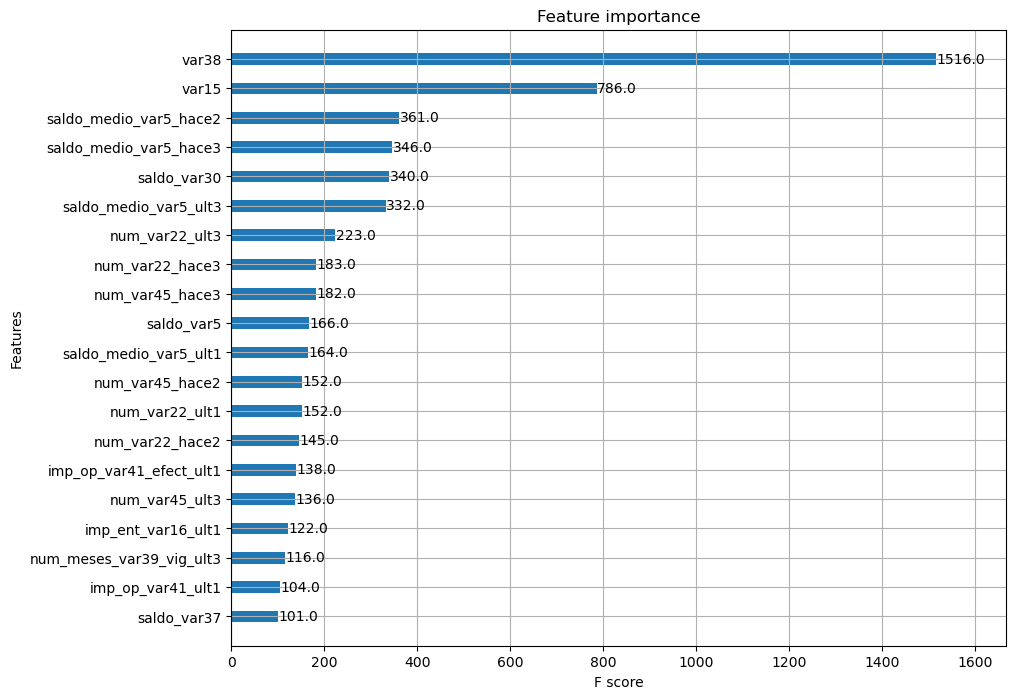

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

## 09.3 LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [40]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[69]	training's auc: 0.925273	training's binary_logloss: 0.105548	valid_1's auc: 0.831952	valid_1's binary_logloss: 0.135527
[70]	training's auc: 0.925899	training's binary_logloss: 0.105314	valid_1's auc: 0.831659	valid_1's binary_logloss: 0.135611
[71]	training's auc: 0.926827	training's binary_logloss: 0.105054	valid_1's auc: 0.831626	valid_1's binary_logloss: 0.135621
[72]	training's auc: 0.927861	training's binary_logloss: 0.104712	valid_1's auc: 0.831612	valid_1's binary_logloss: 0.135665
[73]	training's auc: 0.928078	training's binary_logloss: 0.104537	valid_1's auc: 0.831395	valid_1's binary_logloss: 0.135709
[74]	training's auc: 0.928329	training's binary_logloss: 0.104353	valid_1's auc: 0.831106	valid_1's binary_logloss: 0.135773
[75]	training's auc: 0.928639	training's binary_logloss: 0.104167	valid_1's auc: 0.83094	valid_1's binary_logloss: 0.135819
[76]	training's auc: 0.928812	training's binary_logloss: 0.104032	valid_1's auc: 0.831078	valid_1's binary_logloss: 0.135819
[

ROC AUC: 0.8384


# 10 분류 실습 - 캐글 신용카드 사기 검출

## 10.1 언더 샘플링과 오버 샘플링의 이해

## 10.2 데이터 일차 가공 및 모델 학습/예측/평가

In [41]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [42]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [43]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [44]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [46]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9543


In [47]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [48]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


## 10.3 데이터 분포도 변환 후 모델 학습/예측/평가

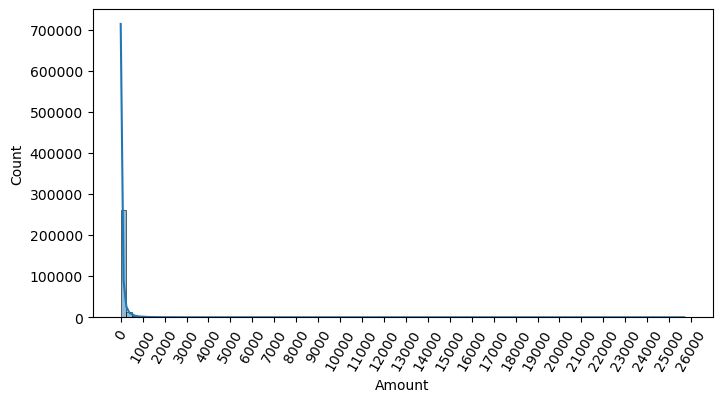

In [49]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [50]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [51]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


In [52]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [53]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


## 10.4 이상치 데이터 제거 후 모델 학습/예측/평가

<AxesSubplot:>

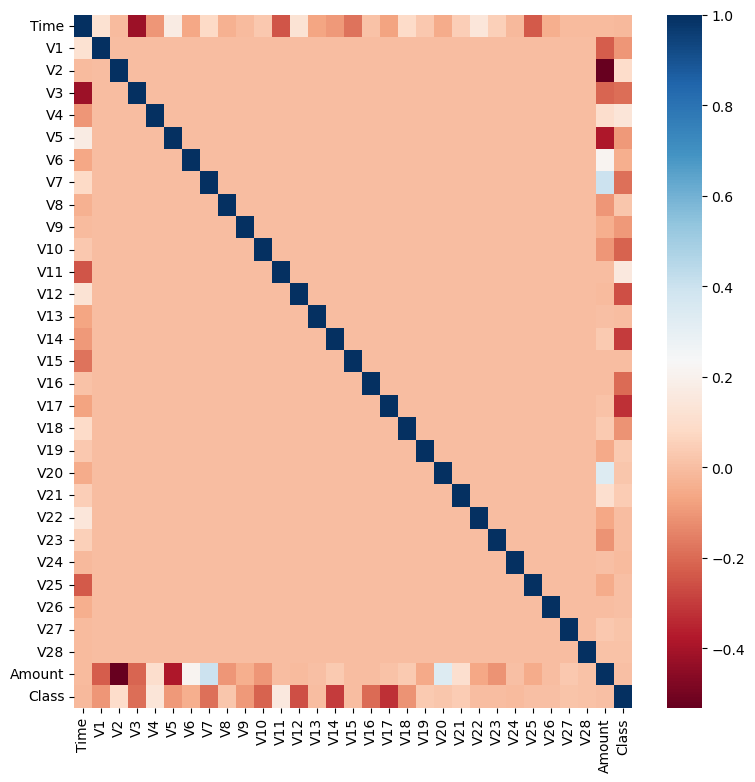

In [54]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [55]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [56]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [57]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


## 10.5 SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [59]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [60]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

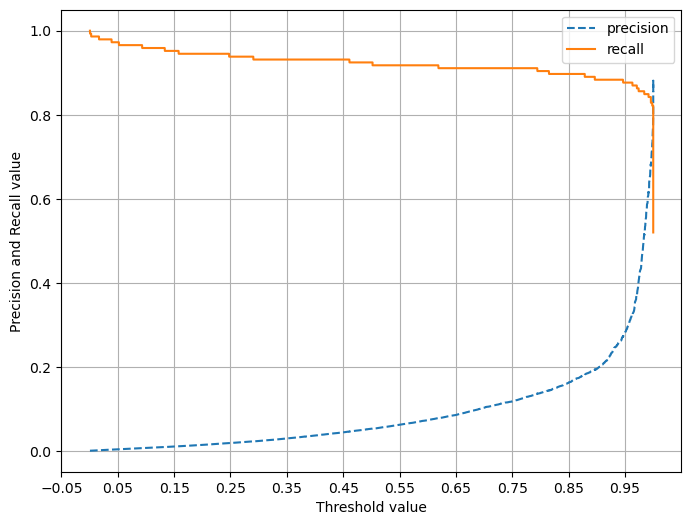

In [62]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [63]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


# 11 스태킹 앙상블

## 11.1 기본 스태킹 모델

In [64]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [65]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

In [66]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [67]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


In [68]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [69]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


## 11.2 CV 세트 기반의 스태킹

In [70]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [71]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [72]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [73]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
